
 # HHM - Referente

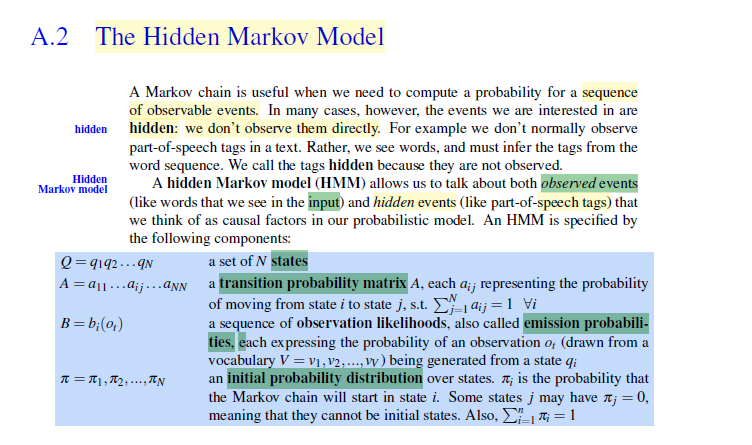

## Cargando librerias de trabajo

In [ ]:
#!pip install statsmodels




  Using cached patsy-1.0.1-py2.py3-none-any.whl.metadata (3.3 kB)
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   --------------------------------- ------ 8.1/9.6 MB 50.4 MB/s eta 0:00:01
   ---------------------------------------- 9.6/9.6 MB 46.2 MB/s eta 0:00:00
Using cached patsy-1.0.1-py2.py3-none-any.whl (232 kB)

   ---------------------------------------- 0/2 [patsy]
   ---------------------------------------- 0/2 [patsy]
   ---------------------------------------- 0/2 [patsy]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [stat


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
from sklearn.cluster import KMeans
from scipy.stats import skew
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import plotly.express as px
import plotly.io as pio
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.cluster import cluster_visualizer_multidim
from pyclustering.utils.metric import distance_metric, type_metric
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

In [2]:
# Ruta absoluta al archivo CSV
csv_path = Path(r"e:\Maestría_Eafit2024\Maestria\Trabajo de grado\DataLab2\archive\data-science-project\data\stage\df_var_obs.csv")

# Leer el CSV directamente
df_XDB = pd.read_csv(csv_path, encoding="utf-8-sig")

# Mostrar primeras filas
df_XDB.head()


,Smoking,Family History of Anxiety,Stress Level,Diet Quality,Anxiety Level,Therapy Sessions (per month),Sleep Hours,Physical Activity (hrs/week),Caffeine Intake (mg/day),Heart Rate (bpm)
0,False,True,0.000000,0.000000,0.4,1.000000,0.50,0.2,0.320534,0.966102
1,False,False,1.000000,0.222222,0.6,0.666667,1.00,0.6,0.612688,0.898305
2,False,False,1.000000,0.555556,1.0,0.111111,0.50,0.0,0.220367,0.322034
3,False,False,0.333333,1.000000,0.2,0.555556,0.50,0.2,0.602671,0.152542
4,False,False,0.222222,0.333333,0.6,0.666667,0.75,0.4,0.886477,0.084746


## Creacion de la columna tiempo y el ID

In [3]:

# Define cuántos pasos quieres por sujeto (mínimo 2)
T = 2
n = len(df_XDB)
n_ids = max(1, n // T)

# Asigna IDs ciclando (1,1,1,2,2,2,3,3,3,...) y baraja si quieres
ids = np.repeat(np.arange(1, n_ids+1), T)[:n]
np.random.seed(42)
np.random.shuffle(ids)

df_XDB_ID = df_XDB.copy()
df_XDB_ID['ID'] = ids

# Crea una fecha simulada por ID con saltos aleatorios (tu estrategia 2)
df_XDB_ID = df_XDB_ID.sort_values('ID').reset_index(drop=True)
df_XDB_ID['fecha'] = (
    pd.to_datetime("2022-01-01") 
    + pd.to_timedelta(
        df_XDB_ID.groupby('ID').cumcount().values * 30  # ~mensual
        + np.random.randint(0, 15, size=len(df_XDB_ID)), # irregularidad
        unit='D'
    )
)

# Orden final y 'time'
df_XDB_ID = df_XDB_ID.sort_values(['ID','fecha']).reset_index(drop=True)
df_XDB_ID['time'] = df_XDB_ID.groupby('ID').cumcount() + 1

In [4]:
df_XDB_ID.head(10)

,Smoking,Family History of Anxiety,Stress Level,Diet Quality,Anxiety Level,Therapy Sessions (per month),Sleep Hours,Physical Activity (hrs/week),Caffeine Intake (mg/day),Heart Rate (bpm),ID,fecha,time
0,False,True,0.888889,0.111111,0.4,0.000000,0.25,0.6,0.293823,0.728814,1,2022-01-03,1
1,False,False,0.111111,0.777778,0.4,0.444444,0.50,0.8,0.779633,0.118644,1,2022-01-31,2
2,True,False,1.000000,0.000000,1.0,1.000000,0.00,0.0,0.816361,0.627119,2,2022-01-08,1
3,False,False,0.666667,0.000000,1.0,0.888889,0.25,0.0,0.218698,0.610169,2,2022-02-12,2
4,False,False,1.000000,0.333333,1.0,0.888889,1.00,0.6,0.984975,0.711864,3,2022-01-13,1
5,True,False,0.555556,0.555556,0.6,0.333333,0.75,0.2,0.420701,0.694915,3,2022-02-09,2
6,False,False,0.555556,0.333333,0.8,0.333333,0.75,0.8,0.026711,0.847458,4,2022-01-14,1
7,True,False,0.000000,0.333333,0.0,0.000000,0.75,1.0,0.330551,0.677966,4,2022-02-10,2
8,False,False,0.000000,0.111111,0.2,0.333333,0.50,0.2,0.824708,0.542373,5,2022-01-15,1
9,True,False,0.111111,0.333333,0.2,0.111111,0.00,0.4,0.871452,0.016949,5,2022-02-10,2


## Procesamiento de datos

In [5]:
# Orden temporal por ID y fecha (si tienes múltiples individuos/series)
# Ajusta el parseo de 'fecha' según formato si es necesario:
df_XDB_ID["fecha"] = pd.to_datetime(df_XDB_ID["fecha"], errors="coerce")
df_XDB_ID = df_XDB_ID.sort_values(["ID", "fecha", "time"], na_position="last").reset_index(drop=True)




# VARIABLE NO OBSERVABLE (Y_d)
# ------------------------------
# Tomamos Anxiety Level como *proxy* de la variable latente y la convertimos a [0,1]
y_cont = df_XDB_ID["Anxiety Level"].astype(float).values.reshape(-1, 1)
y_cont = MinMaxScaler().fit_transform(y_cont)   # 0=sano ... 1=peor (ya no invertimos)



In [6]:
df_XDB_ID.head()

,Smoking,Family History of Anxiety,Stress Level,Diet Quality,Anxiety Level,Therapy Sessions (per month),Sleep Hours,Physical Activity (hrs/week),Caffeine Intake (mg/day),Heart Rate (bpm),ID,fecha,time
0,False,True,0.888889,0.111111,0.4,0.000000,0.25,0.6,0.293823,0.728814,1,2022-01-03,1
1,False,False,0.111111,0.777778,0.4,0.444444,0.50,0.8,0.779633,0.118644,1,2022-01-31,2
2,True,False,1.000000,0.000000,1.0,1.000000,0.00,0.0,0.816361,0.627119,2,2022-01-08,1
3,False,False,0.666667,0.000000,1.0,0.888889,0.25,0.0,0.218698,0.610169,2,2022-02-12,2
4,False,False,1.000000,0.333333,1.0,0.888889,1.00,0.6,0.984975,0.711864,3,2022-01-13,1


In [7]:
display(y_cont)

array([[0.4],
       [0.4],
       [1. ],
       ...,
       [0.6],
       [1. ],
       [0.8]], shape=(22000, 1))

## Modelación 

Se procede con la construcción de la matriz de transición del riesgo para la variable no observable - Anxiety Level

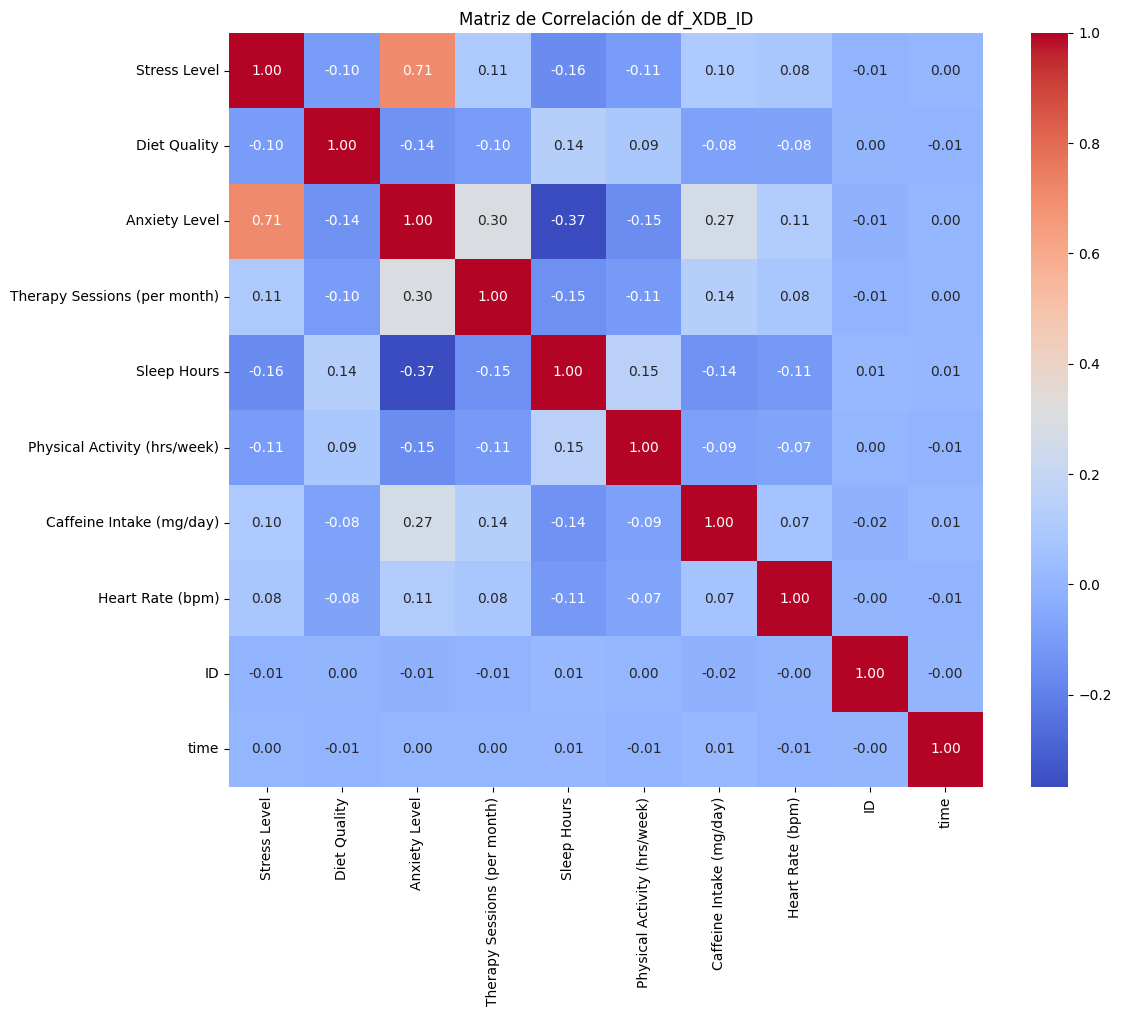

In [8]:

# Selecciona solo las columnas numéricas para la matriz de correlación
corr = df_XDB_ID.select_dtypes(include=['number']).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Matriz de Correlación de df_XDB_ID")
plt.tight_layout()
plt.show()

In [9]:
cols2 = [
    'Smoking', 'Stress Level',
    'Therapy Sessions (per month)', 'Sleep Hours', 'Anxiety Level',
    'Physical Activity (hrs/week)'
]

# Filtra solo las columnas que existen en df_XDB_ID
cols_exist = [col for col in cols2 if col in df_XDB_ID.columns]
df_selected_2  = df_XDB_ID[cols_exist].copy()

df_selected_2.head()

,Smoking,Stress Level,Therapy Sessions (per month),Sleep Hours,Anxiety Level,Physical Activity (hrs/week)
0,False,0.888889,0.000000,0.25,0.4,0.6
1,False,0.111111,0.444444,0.50,0.4,0.8
2,True,1.000000,1.000000,0.00,1.0,0.0
3,False,0.666667,0.888889,0.25,1.0,0.0
4,False,1.000000,0.888889,1.00,1.0,0.6


📊 Matriz de correlaciones parciales (primeras columnas):
                              Stress Level  Therapy Sessions (per month)  \
Stress Level                         1.000                        -0.147   
Therapy Sessions (per month)        -0.147                         1.000   
Sleep Hours                          0.147                        -0.015   
Anxiety Level                        0.709                         0.282   
Physical Activity (hrs/week)        -0.020                        -0.066   

                              Sleep Hours  Anxiety Level  \
Stress Level                        0.147          0.709   
Therapy Sessions (per month)       -0.015          0.282   
Sleep Hours                         1.000         -0.335   
Anxiety Level                      -0.335          1.000   
Physical Activity (hrs/week)        0.104         -0.047   

                              Physical Activity (hrs/week)  
Stress Level                                        -0.020  
The

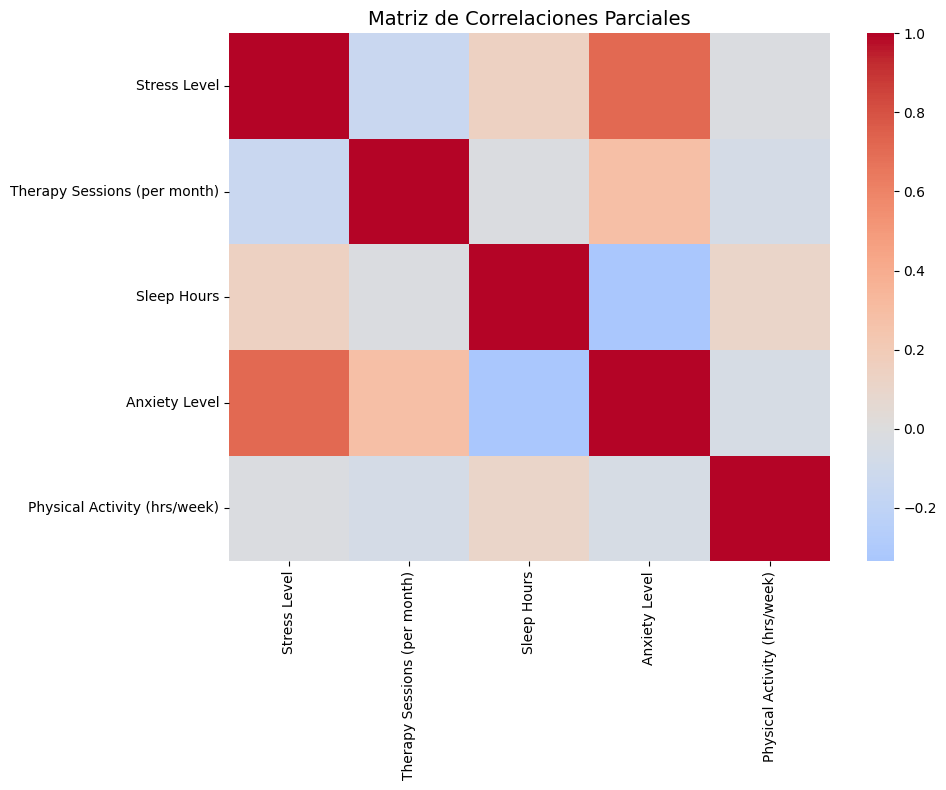

In [10]:
# ==========================================
# 📘 Cálculo de correlaciones parciales
# ==========================================

# 1️⃣ Cargar dataset
df = df_selected_2.copy()

# 2️⃣ Seleccionar solo las columnas numéricas
df_numeric = df.select_dtypes(include=[np.number]).dropna()

# 3️⃣ Estandarizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_numeric)

# 4️⃣ Calcular la matriz de correlación de Pearson
corr_matrix = np.corrcoef(X_scaled, rowvar=False)

# 5️⃣ Regularización para evitar singularidad (ridge regularization)
ridge = 1e-5
corr_matrix_reg = corr_matrix + ridge * np.eye(corr_matrix.shape[0])

# 6️⃣ Invertir la matriz de correlación regularizada
precision_matrix = np.linalg.inv(corr_matrix_reg)

# 7️⃣ Calcular correlaciones parciales
D = np.sqrt(np.diag(precision_matrix))
partial_corr_matrix = -precision_matrix / np.outer(D, D)
np.fill_diagonal(partial_corr_matrix, 1)

# 8️⃣ Convertir a DataFrame
partial_corr_df = pd.DataFrame(
    partial_corr_matrix,
    index=df_numeric.columns,
    columns=df_numeric.columns
)

# 9️⃣ Mostrar primeras filas
print("📊 Matriz de correlaciones parciales (primeras columnas):")
print(partial_corr_df.round(3).iloc[:10, :10])

# 🔟 Visualización tipo heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(partial_corr_df, cmap="coolwarm", center=0, annot=False)
plt.title("Matriz de Correlaciones Parciales", fontsize=14)
plt.tight_layout()
plt.show()


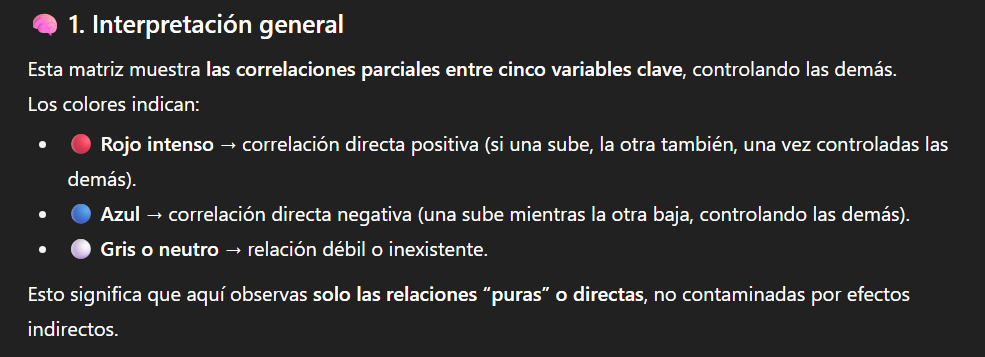

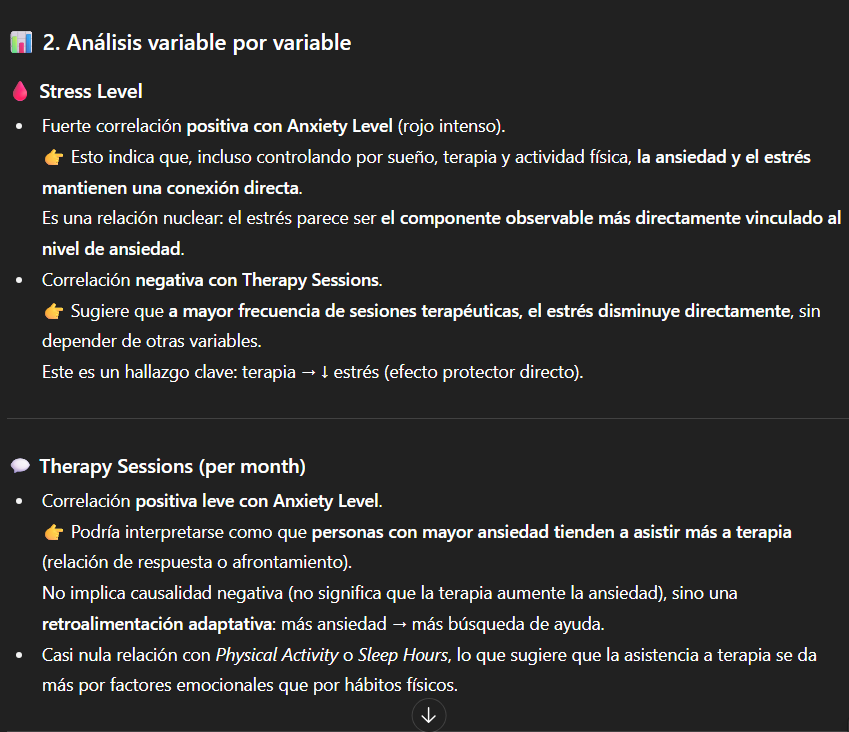

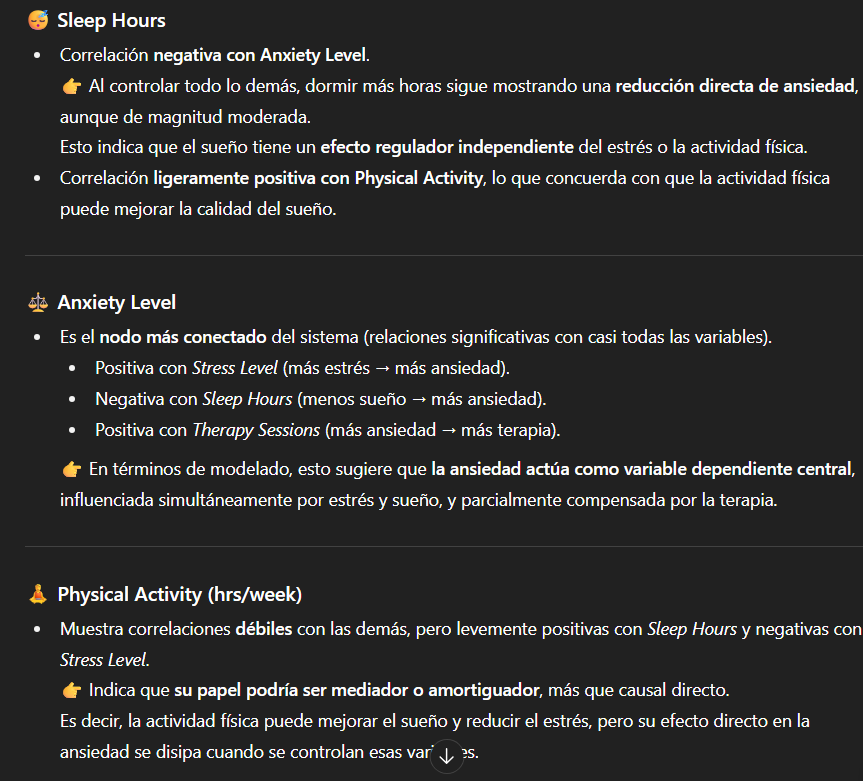

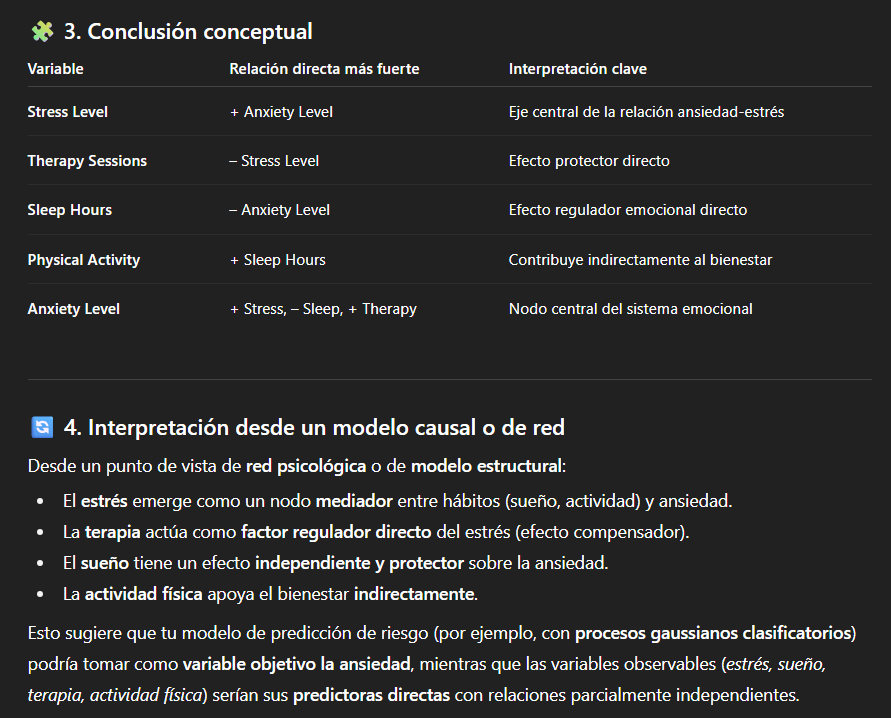

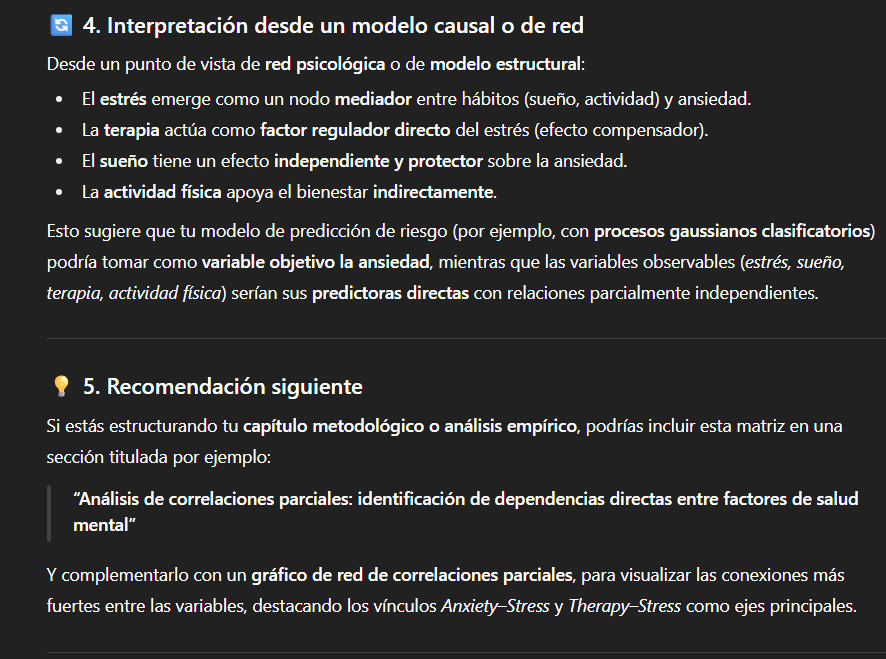

### Analisis de la variable binaria

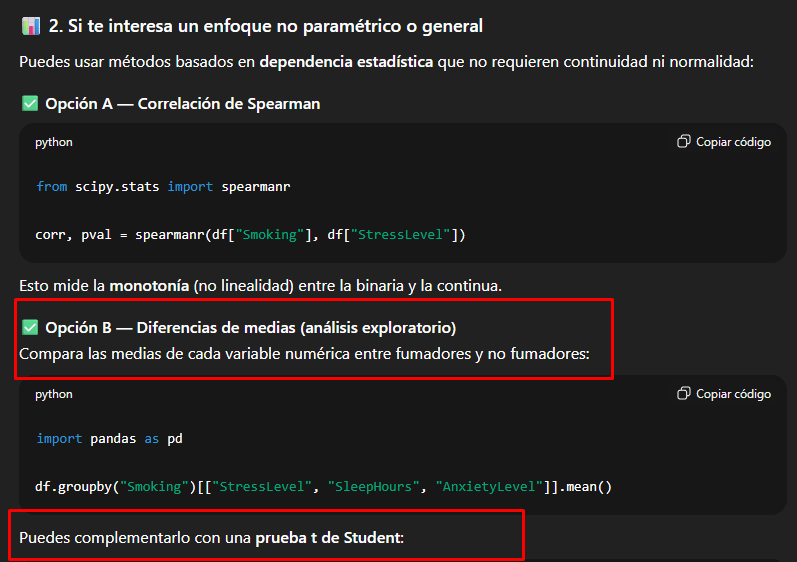

In [14]:
import pandas as pd

df.groupby("Smoking")[["Stress Level", "Sleep Hours", "Anxiety Level"]].mean()


,Stress Level,Sleep Hours,Anxiety Level
Smoking,,,
False,0.533563,0.546716,0.547378
True,0.542547,0.516993,0.551669


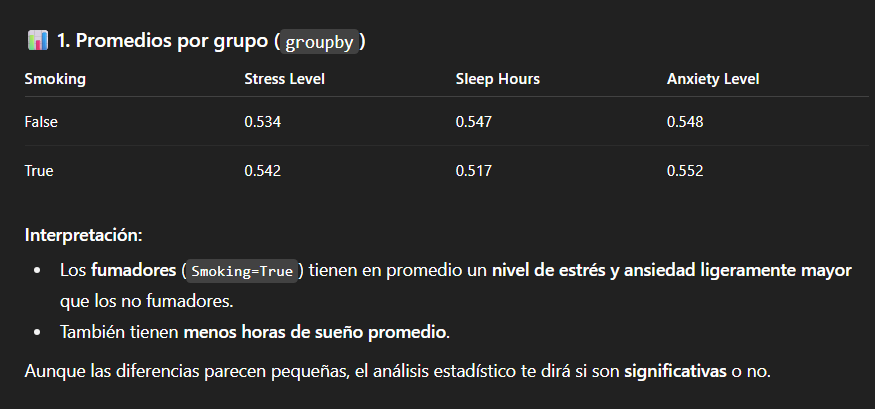

In [16]:
from scipy.stats import ttest_ind

smokers = df[df["Smoking"]==1]["Stress Level"]
nonsmokers = df[df["Smoking"]==0]["Stress Level"]

t, p = ttest_ind(smokers, nonsmokers)
print(f"t={t:.3f}, p={p:.4f}")


t=1.979, p=0.0478


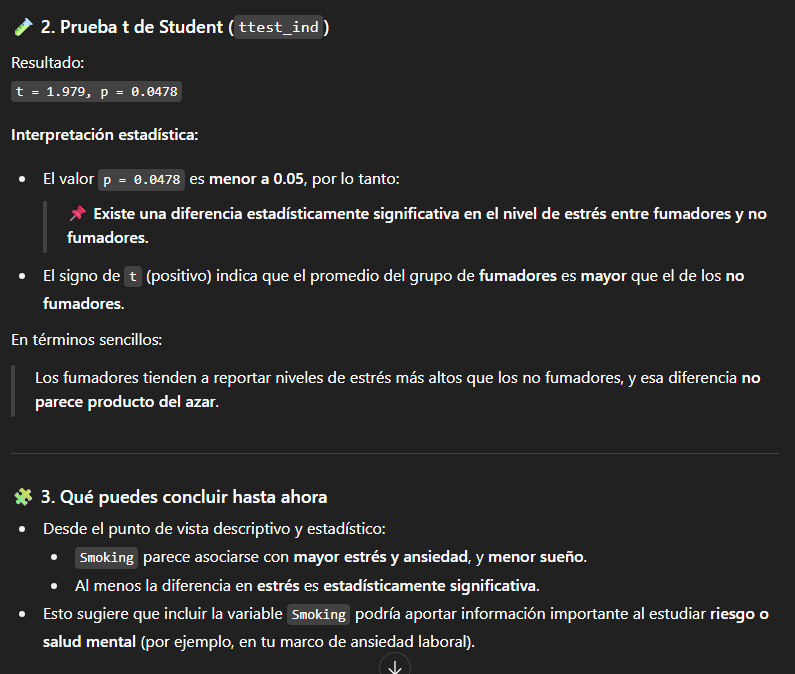

In [17]:
for var in ["Stress Level", "Sleep Hours", "Anxiety Level"]:
    smokers = df[df["Smoking"]==1][var]
    nonsmokers = df[df["Smoking"]==0][var]
    t, p = ttest_ind(smokers, nonsmokers)
    print(f"{var}: t={t:.3f}, p={p:.4f}")


Stress Level: t=1.979, p=0.0478
Sleep Hours: t=-6.729, p=0.0000
Anxiety Level: t=1.004, p=0.3156


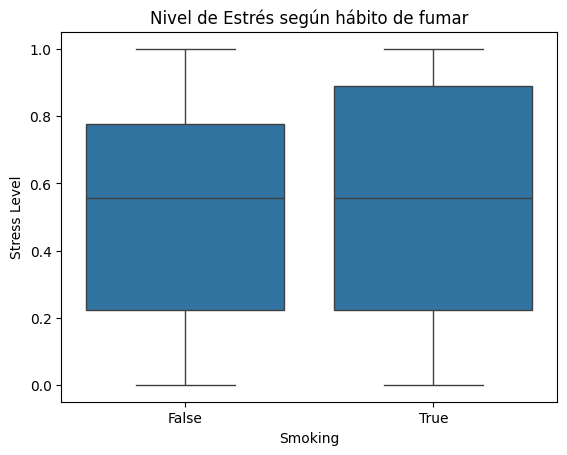

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x="Smoking", y="Stress Level", data=df)
plt.title("Nivel de Estrés según hábito de fumar")
plt.show()


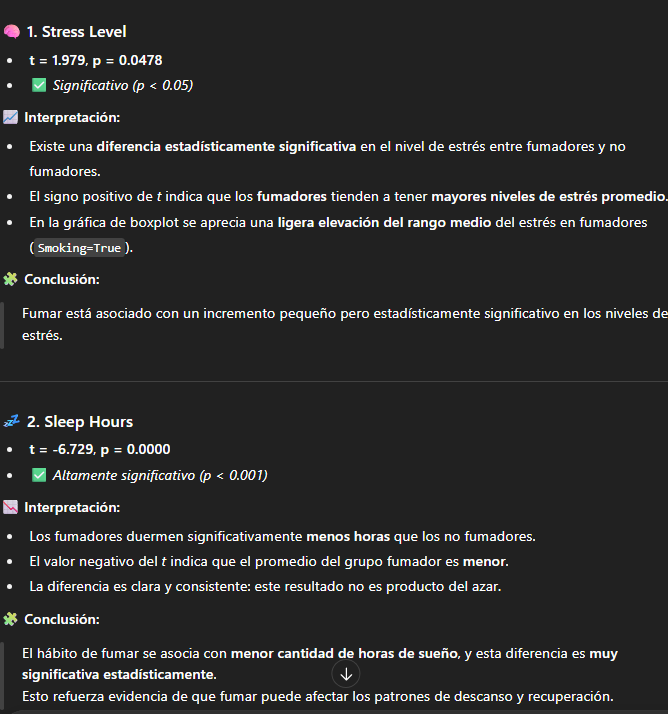

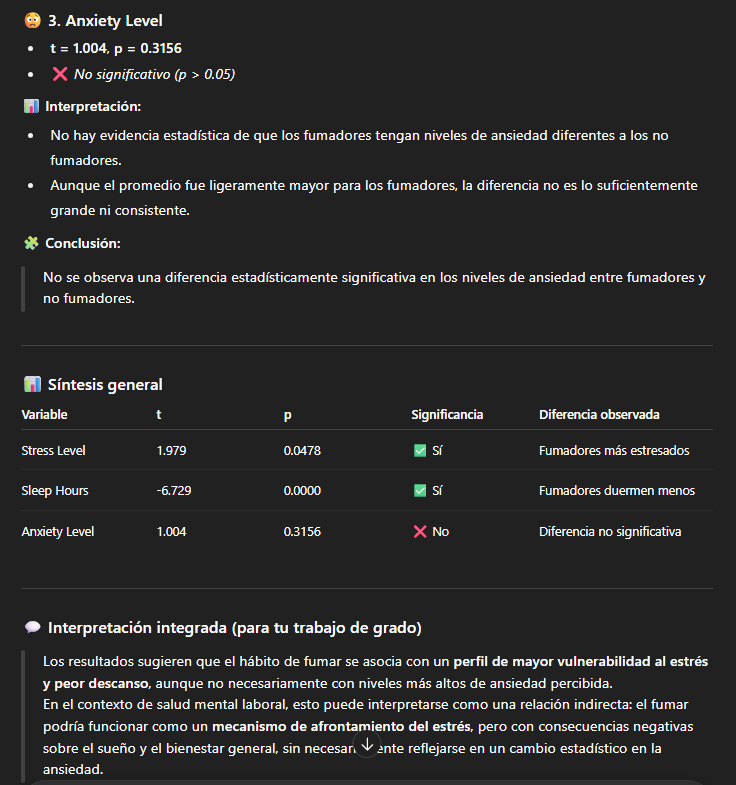

In [22]:
# ==========================================
# 📘 Correlación múltiple (R) con statsmodels
# ==========================================
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

# ---------- Utilidades ----------
def multiple_correlation(y: pd.Series, X: pd.DataFrame, standardize=True):
    """
    Devuelve R, R2, R2_ajustado, F, p_global y coeficientes beta estandarizados.
    y: variable objetivo (Series)
    X: predictores (DataFrame)
    """
    # Quitar filas con NaN en y o X
    data = pd.concat([y, X], axis=1).dropna()
    y_clean = data.iloc[:, 0].astype(float)
    X_clean = data.iloc[:, 1:].astype(float)

    # Estandarizar (opcional, útil para betas comparables)
    if standardize:
        scaler = StandardScaler()
        X_std = pd.DataFrame(scaler.fit_transform(X_clean), columns=X_clean.columns, index=X_clean.index)
        y_std = pd.Series(StandardScaler().fit_transform(y_clean.values.reshape(-1,1)).ravel(),
                          name=y_clean.name, index=y_clean.index)
    else:
        X_std, y_std = X_clean, y_clean

    # Ajuste OLS
    X_sm = sm.add_constant(X_std)
    model = sm.OLS(y_std, X_sm).fit()

    R2 = model.rsquared
    R = np.sqrt(max(R2, 0))
    R2_adj = model.rsquared_adj
    F = model.fvalue
    p_global = model.f_pvalue

    # Coeficientes beta (al estar estandarizado, son betas estandarizadas)
    betas = model.params.drop('const')
    betas = betas.sort_values(key=lambda s: s.abs(), ascending=False)

    return {
        "R": R,
        "R2": R2,
        "R2_adj": R2_adj,
        "F": F,
        "p_global": p_global,
        "betas_std": betas,
        "resumen_modelo": model.summary()
    }

def multiple_correlation_for_all(df: pd.DataFrame, standardize=True):
    """
    Calcula R de correlación múltiple para cada columna como objetivo frente al resto.
    Devuelve un DataFrame con R, R2, R2_ajustado y p_global.
    """
    df_num = df.select_dtypes(include=[np.number, "bool"])
    results = []
    for target in df_num.columns:
        X = df_num.drop(columns=[target])
        y = df_num[target]
        out = multiple_correlation(y, X, standardize=standardize)
        results.append({
            "target": target,
            "R": out["R"],
            "R2": out["R2"],
            "R2_adj": out["R2_adj"],
            "p_global": out["p_global"]
        })
    return pd.DataFrame(results).sort_values("R", ascending=False)

# ---------- Ejemplos de uso ----------
# 1) Cargar tu dataset
df = df_selected_2.copy()


# 2) Correlación múltiple para un objetivo específico (p. ej., Anxiety Level)
target_col = "Anxiety Level"              # <- cambia aquí si quieres otra
X = df.drop(columns=[target_col]).select_dtypes(include=[np.number, "bool"])
y = df[target_col]

res = multiple_correlation(y, X, standardize=True)

print(f"Objetivo: {target_col}")
print(f"R = {res['R']:.3f} | R2 = {res['R2']:.3f} | R2 ajustado = {res['R2_adj']:.3f}")
print(f"F = {res['F']:.3f} | p global = {res['p_global']:.3g}\n")
print("Betas estandarizadas (ordenadas por |β|):")
print(res["betas_std"].round(3))
# Si quieres ver el resumen OLS completo:
# print(res["resumen_modelo"])

# 3) (Opcional) R múltiple para todas las columnas como objetivo
tabla_R = multiple_correlation_for_all(df)
print("\nCorrelación múltiple por variable objetivo:")
print(tabla_R.round(3))


Objetivo: Anxiety Level
R = 0.776 | R2 = 0.602 | R2 ajustado = 0.602
F = 6655.555 | p global = 0

Betas estandarizadas (ordenadas por |β|):
Stress Level                    0.646
Sleep Hours                    -0.231
Therapy Sessions (per month)    0.190
Physical Activity (hrs/week)   -0.030
Smoking                         0.006
dtype: float64

Correlación múltiple por variable objetivo:
                         target      R     R2  R2_adj  p_global
4                 Anxiety Level  0.776  0.602   0.602       0.0
1                  Stress Level  0.722  0.521   0.521       0.0
3                   Sleep Hours  0.408  0.166   0.166       0.0
2  Therapy Sessions (per month)  0.351  0.123   0.123       0.0
5  Physical Activity (hrs/week)  0.198  0.039   0.039       0.0
0                       Smoking  0.120  0.014   0.014       0.0


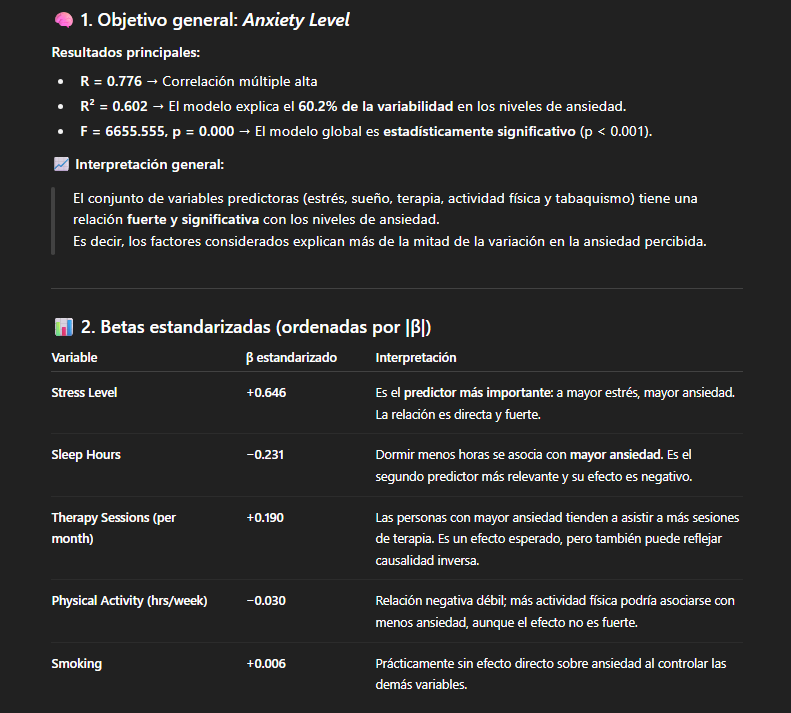

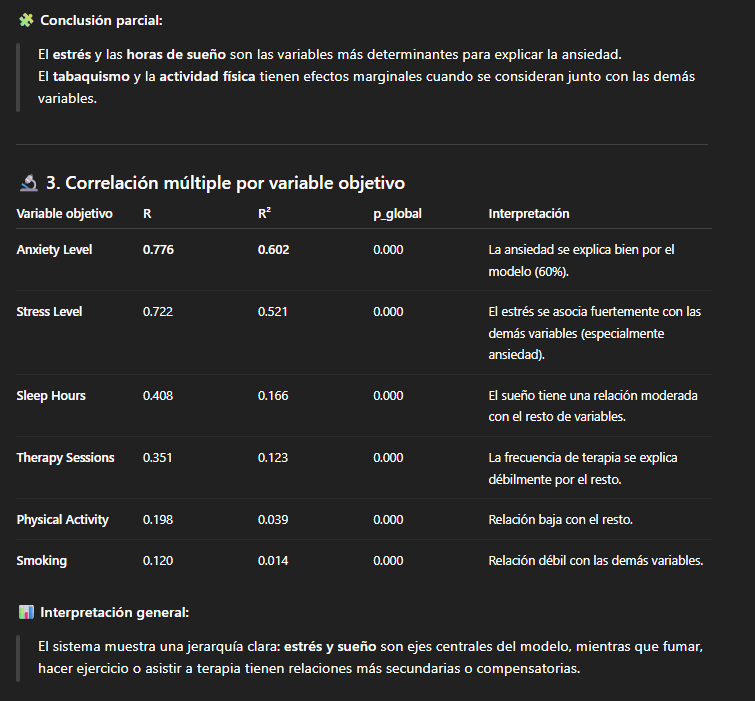

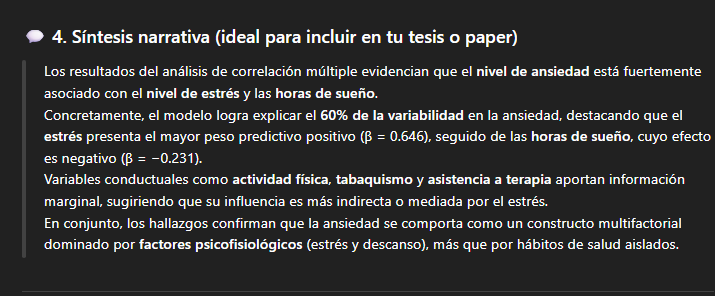

In [36]:
# ==========================================
# 📘 Correlación múltiple sin "Physical Activity (hrs/week)"
# ==========================================

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

# ---------- Utilidades (las mismas que ya tienes) ----------
# (puedes dejar tus funciones multiple_correlation y multiple_correlation_for_all tal cual)

# ---------- Cargar dataset ----------
df = df_selected_2.copy()

# ---------- Variable objetivo ----------
target_col = "Anxiety Level"

# ---------- Construir X excluyendo la variable deseada ----------
cols_to_exclude = [target_col, "Physical Activity (hrs/week)"]
X = df.drop(columns=cols_to_exclude).select_dtypes(include=[np.number, "bool"])
y = df[target_col]

# ---------- Calcular correlación múltiple ----------
res = multiple_correlation(y, X, standardize=True)

print(f"Objetivo: {target_col}")
print(f"R = {res['R']:.3f} | R2 = {res['R2']:.3f} | R2 ajustado = {res['R2_adj']:.3f}")
print(f"F = {res['F']:.3f} | p global = {res['p_global']:.3g}\n")
print("Betas estandarizadas (ordenadas por |β|):")
print(res["betas_std"].round(3))

# ---------- (Opcional) Comparar con el modelo completo ----------
tabla_R = multiple_correlation_for_all(df.drop(columns=["Physical Activity (hrs/week)"]))
print("\nCorrelación múltiple por variable objetivo (sin Physical Activity):")
print(tabla_R.round(3))


Objetivo: Anxiety Level
R = 0.776 | R2 = 0.602 | R2 ajustado = 0.602
F = 4758.636 | p global = 0

Betas estandarizadas (ordenadas por |β|):
Sleep Hours                     2.147954e+12
PC3                            -1.754555e+12
PC1                            -1.088527e+12
Therapy Sessions (per month)    5.866063e+11
PC2                            -5.353840e+11
Stress Level                    7.325118e+10
Behavioral_Index                3.900000e-02
Smoking                         3.000000e-03
Cluster                        -3.000000e-03
dtype: float64

Correlación múltiple por variable objetivo (sin Physical Activity):
                         target      R     R2  R2_adj  p_global
2  Therapy Sessions (per month)  1.000  1.000   1.000       0.0
8                           PC3  1.000  1.000   1.000       0.0
1                  Stress Level  1.000  1.000   1.000       0.0
3                   Sleep Hours  1.000  1.000   1.000       0.0
6                           PC1  1.000  1.000   1.0

### clusterización con K means 

Varianza explicada por los 3 primeros componentes: 0.8010850162213943


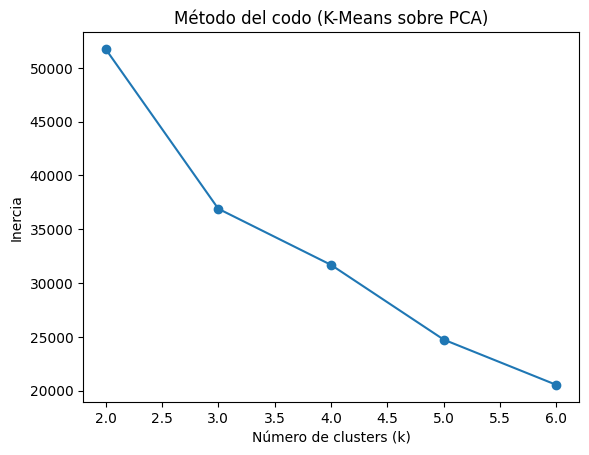

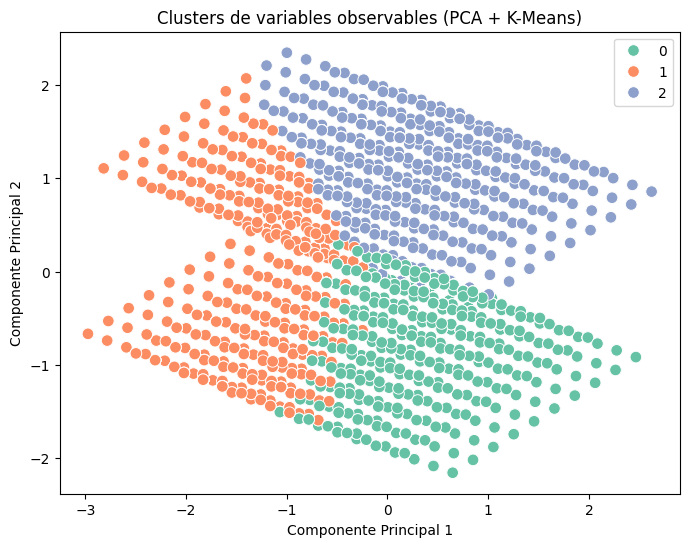

In [58]:
# ==========================================
# 📘 Reducción y clusterización de variables observables
# ==========================================
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Cargar dataset y seleccionar variables observables
df = df_selected_2.copy()
observables = ["Stress Level", "Sleep Hours", "Therapy Sessions (per month)","Smoking"] #,"Physical Activity (hrs/week)" 
X = df[observables].dropna()

# 2️⃣ Escalamiento
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3️⃣ Reducción de dimensionalidad con PCA
pca = PCA(n_components=3)   # puedes cambiar a 3 si quieres visualización 3D
X_pca = pca.fit_transform(X_scaled)
print("Varianza explicada por los 3 primeros componentes:", pca.explained_variance_ratio_.sum())

# 4️⃣ Determinar número óptimo de clusters (Método del codo)
inertia = []
for k in range(2, 7):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_pca)
    inertia.append(km.inertia_)

plt.plot(range(2, 7), inertia, 'o-')
plt.title("Método del codo (K-Means sobre PCA)")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inercia")
plt.show()

# 5️⃣ Elegir k óptimo (por ejemplo, 3) y clusterizar
k_opt = 3
kmeans = KMeans(n_clusters=k_opt, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# 6️⃣ Agregar el cluster como nueva variable sintética
df["Behavioral_Cluster"] = clusters

# 7️⃣ Visualización en el espacio PCA
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=clusters, palette="Set2", s=70)
plt.title("Clusters de variables observables (PCA + K-Means)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.show()

# 8️⃣ (Opcional) Crear una variable numérica latente (distancia al centroide o proyección)
df["Behavioral_Index"] = kmeans.transform(X_pca).min(axis=1)
df["Behavioral_Index"] = 1 - (df["Behavioral_Index"] - df["Behavioral_Index"].min()) / (df["Behavioral_Index"].max() - df["Behavioral_Index"].min())


Varianza explicada por los 3 componentes: 0.8010850162213943


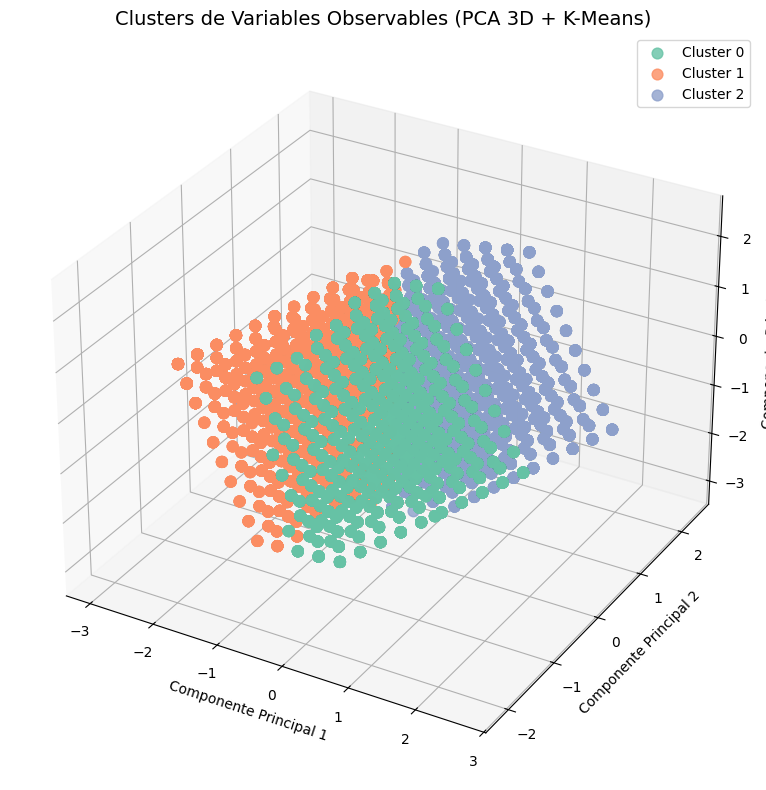

In [61]:
# ==========================================
# 📊 Clustering con PCA (3D) y K-Means
# ==========================================
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# 1️⃣ Cargar dataset
df = df_selected_2

# 2️⃣ Definir variables observables
observables = ["Stress Level", "Sleep Hours", "Therapy Sessions (per month)", "Smoking"] #, "Smoking","Physical Activity (hrs/week)"
X = df[observables].dropna()

# 3️⃣ Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4️⃣ Reducir dimensionalidad a 3 componentes con PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)
print("Varianza explicada por los 3 componentes:", pca.explained_variance_ratio_.sum())

# 5️⃣ Aplicar K-Means (ajusta k según el método del codo anterior)
k_opt = 3
kmeans = KMeans(n_clusters=k_opt, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# 6️⃣ Agregar resultados al dataframe
df["Cluster"] = clusters
df["PC1"], df["PC2"], df["PC3"] = X_pca[:, 0], X_pca[:, 1], X_pca[:, 2]

# 7️⃣ Graficar en 3D
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

# Colores personalizados
colors = sns.color_palette("Set2", k_opt)

for i in range(k_opt):
    subset = df[df["Cluster"] == i]
    ax.scatter(subset["PC1"], subset["PC2"], subset["PC3"], 
               s=60, alpha=0.8, color=colors[i], label=f"Cluster {i}")

# 8️⃣ Etiquetas y detalles
ax.set_title("Clusters de Variables Observables (PCA 3D + K-Means)", fontsize=14)
ax.set_xlabel("Componente Principal 1")
ax.set_ylabel("Componente Principal 2")
ax.set_zlabel("Componente Principal 3")
ax.legend()
plt.tight_layout()
plt.show()

# 9️⃣ (Opcional) Calcular un índice continuo de bienestar observable
df["Behavioral_Index"] = 1 - (kmeans.transform(X_pca).min(axis=1) / np.max(kmeans.transform(X_pca)))


In [60]:
# ==========================
# 1. Configurar renderizador
# ==========================
import plotly.io as pio
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import pandas as pd

pio.renderers.default = "browser"   # abrirá el gráfico en tu navegador por defecto

# ==========================
# 2. Cargar dataset
# ==========================
df_selected = df_selected_2.copy()

# ==========================
# 3. Variables observables (quitamos Anxiety Level)
# ==========================
observables = df_selected.drop(columns=["Anxiety Level"]).dropna()

# ==========================
# 4. Ajustar K-Means con k=3
# ==========================
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_selected["Cluster_KMeans"] = kmeans.fit_predict(observables)

# ==========================
# 5. Reducir a 3D con PCA
# ==========================
pca = PCA(n_components=3, random_state=42)
X3 = pca.fit_transform(observables)

df_selected["PC1"] = X3[:, 0]
df_selected["PC2"] = X3[:, 1]
df_selected["PC3"] = X3[:, 2]

# ==========================
# 6. Visualización 3D interactiva con Plotly
# ==========================
fig = px.scatter_3d(
    df_selected,
    x="PC1", y="PC2", z="PC3",
    color=df_selected["Cluster_KMeans"].astype(str),  # clusters como categorías
    symbol=df_selected["Cluster_KMeans"].astype(str),
    hover_data=["Stress Level", "Sleep Hours", "Therapy Sessions (per month)", "Smoking"], #, "Therapy Sessions (per month)", "Smoking"
    title="Clusters K-Means en 3D (PCA)",
    opacity=0.8
)

# Mostrar directamente en navegador
fig.show()

# ==========================
# 7. Guardar gráfico en HTML
# ==========================
fig.write_html("clusters_kmeans_3d.html", include_plotlyjs="cdn", auto_open=True)

print("✅ Archivo 'clusters_kmeans_3d.html' generado correctamente.")



✅ Archivo 'clusters_kmeans_3d.html' generado correctamente.


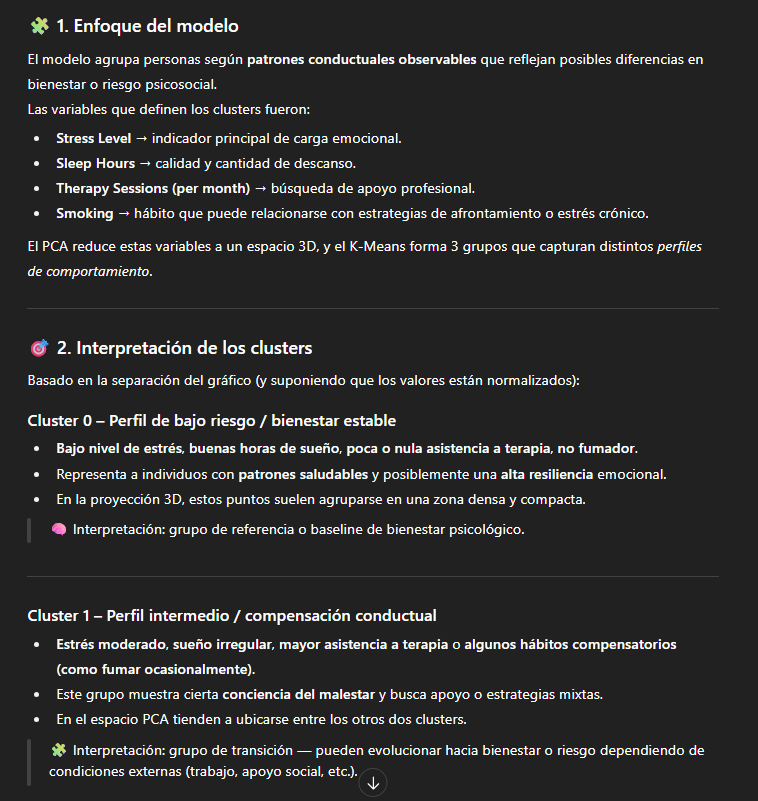

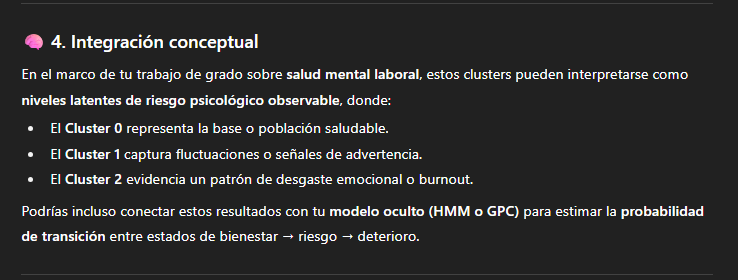

In [70]:
df_selected_2.groupby("Cluster_Observables_Vector")[["Stress Level","Sleep Hours","Therapy Sessions (per month)","Smoking"]].mean()


,Stress Level,Sleep Hours,Therapy Sessions (per month),Smoking
Cluster_Observables_Vector,,,,
0,0.818828,0.186294,0.713449,0.331090
1,0.594909,0.528203,0.403762,0.346416
2,0.311175,0.738581,0.207649,0.435667


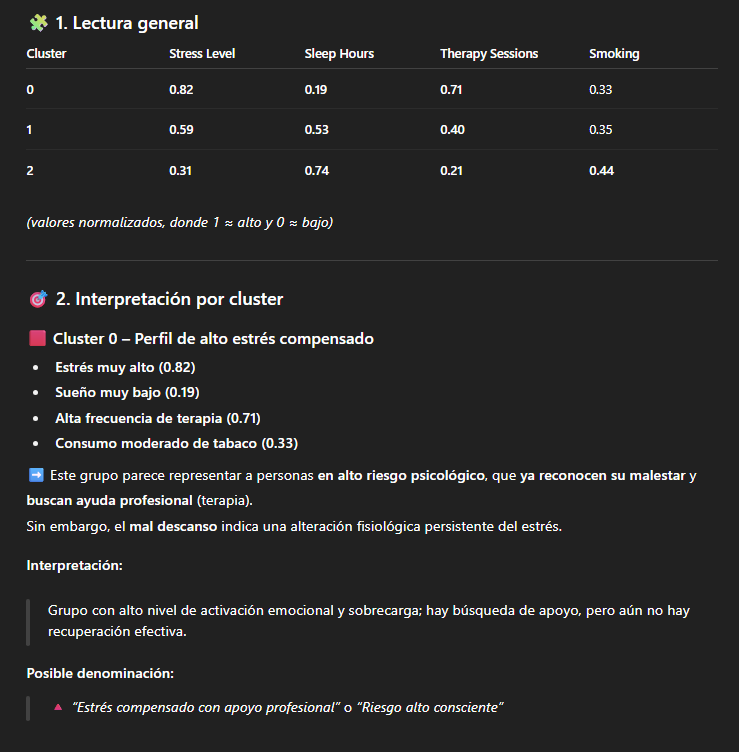

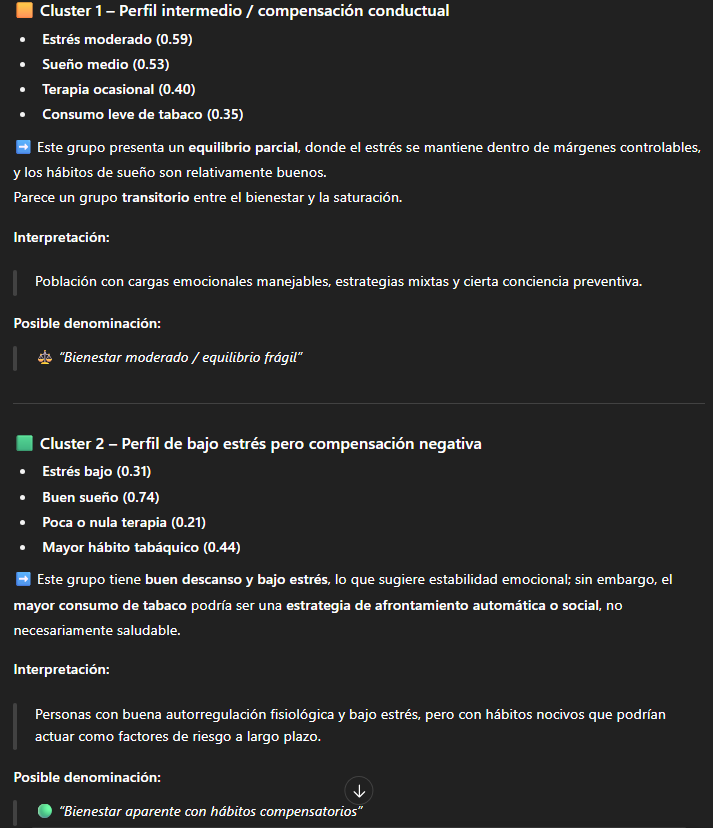

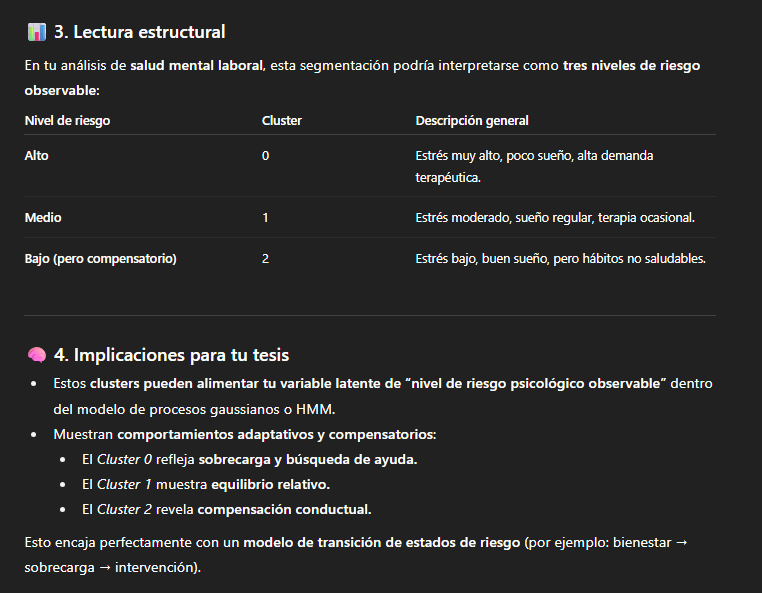

   k  Silhouette  Calinski-Harabasz  Davies-Bouldin
0  3    0.314656       10013.122896        1.169011
1  4    0.291498        8980.204338        1.097928


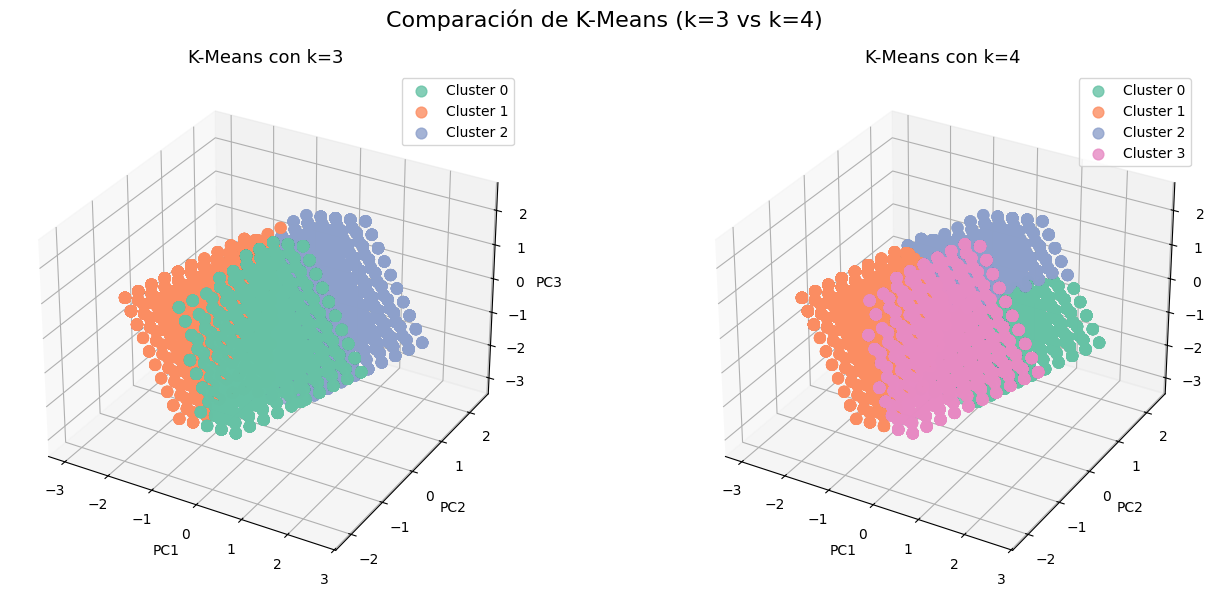

In [57]:
# ==========================================
# 📊 Comparación de K-Means con k=3 y k=4
# ==========================================
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

results = []

for k in [3, 4]:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_pca)

    sil = silhouette_score(X_pca, labels)
    cal = calinski_harabasz_score(X_pca, labels)
    dav = davies_bouldin_score(X_pca, labels)

    results.append({
        "k": k,
        "Silhouette": sil,
        "Calinski-Harabasz": cal,
        "Davies-Bouldin": dav
    })

# Convertir a DataFrame para fácil comparación
df_scores = pd.DataFrame(results)
print(df_scores)

# ==========================================
# 🎨 Visualización comparativa de clusters
# ==========================================
fig = plt.figure(figsize=(14,6))

for idx, k in enumerate([3,4]):
    ax = fig.add_subplot(1,2,idx+1, projection='3d')
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_pca)
    
    colors = sns.color_palette("Set2", k)
    for i in range(k):
        subset = X_pca[labels == i]
        ax.scatter(subset[:,0], subset[:,1], subset[:,2], 
                   s=60, alpha=0.8, color=colors[i], label=f"Cluster {i}")
    
    ax.set_title(f"K-Means con k={k}", fontsize=13)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    ax.legend()

plt.suptitle("Comparación de K-Means (k=3 vs k=4)", fontsize=16)
plt.tight_layout()
plt.show()


In [62]:
# ======================================================
# 🧩 Almacenado de resultados de clusterización observables
# ======================================================
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

# --- 1) Seleccionar variables observables ---
observables = ["Stress Level", "Sleep Hours", "Therapy Sessions (per month)", "Smoking"]
X = df_selected_2[observables].dropna().to_numpy()

# --- 2) Escalado ---
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# --- 3) PCA 1D para proyección XP ---
pca = PCA(n_components=1)
XP = pca.fit_transform(X_std)  # shape: (n, 1)

# --- 4) K-Means sobre XP ---
k_optimo = 3   # según tu método del codo
mkm = KMeans(n_clusters=k_optimo, random_state=42, n_init=10)
mkm.fit(XP)

# --- 5) Centroides ordenados ---
XCp = np.sort(mkm.cluster_centers_.flatten()).reshape(-1, 1)

# --- 6) Asignar cluster por distancia al centroide más cercano ---
cluster_var_obs = np.zeros(len(XP), dtype=int)
for i in range(len(XP)):
    dist = np.abs(XCp - XP[i, 0])
    cluster_var_obs[i] = np.argmin(dist)

# --- 7) Guardar resultados en DataFrame original ---
df_selected_2["Cluster_Observables_Vector"] = cluster_var_obs
df_selected_2["XP"] = XP

# --- 8) Crear DataFrame final para almacenamiento ---
df_varobs_kmeans = df_selected_2[observables].copy()
df_varobs_kmeans["XP"] = XP
df_varobs_kmeans["Cluster_Observables_Vector"] = cluster_var_obs


# --- 9) Exportar a CSV ---
#output_path = "df_varobs_kmeans.csv"
#df_varobs_kmeans.to_csv(output_path, index=False, encoding="utf-8-sig")

#print(f"✅ Archivo guardado exitosamente en: {output_path}")
print(df_varobs_kmeans.head())
print("\nDistribución por cluster:")
print(df_varobs_kmeans["Cluster_Observables_Vector"].value_counts())


   Stress Level  Sleep Hours  Therapy Sessions (per month)  Smoking        XP  \
0      0.888889         0.25                      0.000000    False -0.487883   
1      0.111111         0.50                      0.444444    False  0.514386   
2      1.000000         0.00                      1.000000     True -2.817384   
3      0.666667         0.25                      0.888889    False -1.723290   
4      1.000000         1.00                      0.888889    False -0.866365   

   Cluster_Observables_Vector  
0                           1  
1                           2  
2                           0  
3                           0  
4                           1  

Distribución por cluster:
Cluster_Observables_Vector
1    9529
2    8013
0    4458
Name: count, dtype: int64


In [65]:
# 🧹 Eliminar variables observables del DataFrame df_varobs_kmeans
vars_to_drop = ["Stress Level", "Sleep Hours", "Therapy Sessions (per month)", "Smoking"]

df_varobs_kmeans = df_varobs_kmeans.drop(columns=vars_to_drop, errors="ignore")


df_varobs_kmeans.head()


,XP,Cluster_Observables_Vector
0,-0.487883,1
1,0.514386,2
2,-2.817384,0
3,-1.723290,0
4,-0.866365,1


## Modelación - Variables no observables

In [66]:
cols = [
    'Anxiety Level'
]

# Filtra solo las columnas que existen en df_XDB_ID
cols_exist = [col for col in cols if col in df_XDB_ID.columns]
df_anx  = df_XDB_ID[cols_exist].copy()


In [28]:
df_anx.head()

,Anxiety Level
0,0.4
1,0.4
2,1.0
3,1.0
4,1.0


e:\Maestría_Eafit2024\Maestria\Trabajo de grado\DataLab2\archive\.venv\Lib\site-packages\sklearn\base.py:1365: ConvergenceWarning:

Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.

e:\Maestría_Eafit2024\Maestria\Trabajo de grado\DataLab2\archive\.venv\Lib\site-packages\sklearn\base.py:1365: ConvergenceWarning:

Number of distinct clusters (6) found smaller than n_clusters (8). Possibly due to duplicate points in X.

e:\Maestría_Eafit2024\Maestria\Trabajo de grado\DataLab2\archive\.venv\Lib\site-packages\sklearn\base.py:1365: ConvergenceWarning:

Number of distinct clusters (6) found smaller than n_clusters (9). Possibly due to duplicate points in X.



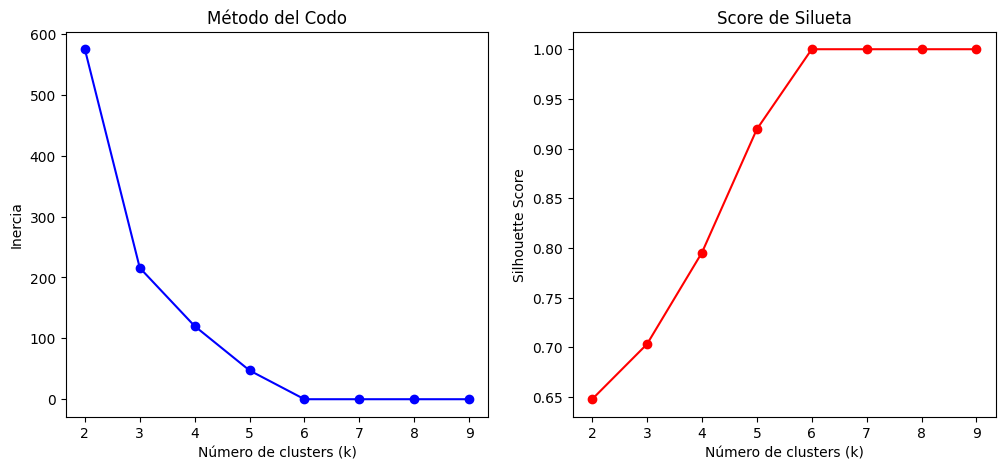

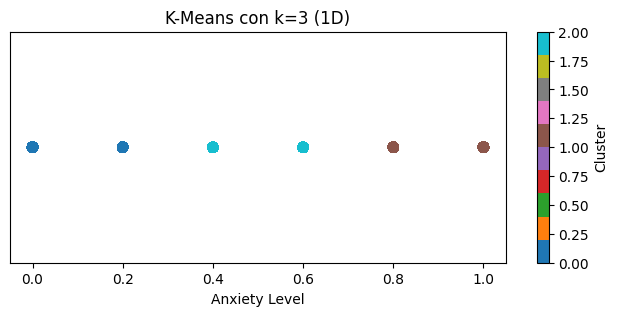

Cluster_KMeans
2    9568
1    7307
0    5125
Name: count, dtype: int64
                Anxiety Level
Cluster_KMeans               
0                    0.128000
1                    0.905707
2                    0.502069


In [74]:
### K-Means
# --- 0) Datos ---




# 1. Cargar dataset
# 2. Seleccionar variables no_observables
no_observables = df_anx

# 3. Método del codo para elegir k
inertia = []
silhouette = []
K_range = range(2, 10)  # probar entre 2 y 9 clusters

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(no_observables)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(no_observables, kmeans.labels_))

# Graficar método del codo
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo')

plt.subplot(1,2,2)
plt.plot(K_range, silhouette, 'ro-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Score de Silueta')

plt.show()

# 4. Ajustar modelo con el k óptimo (ejemplo k=3)
k_optimo = 3
kmeans = KMeans(n_clusters=k_optimo, random_state=42, n_init=10)
df_selected["Cluster_KMeans"] = kmeans.fit_predict(no_observables)

# 5. Visualización en 1D (solo hay una variable)
plt.figure(figsize=(8, 3))
plt.scatter(no_observables.values.flatten(), np.zeros_like(no_observables.values), 
            c=df_selected["Cluster_KMeans"], cmap="tab10", s=50)
plt.title(f"K-Means con k={k_optimo} (1D)")
plt.xlabel("Anxiety Level")
plt.yticks([])
plt.colorbar(label="Cluster")
plt.show()

# 6. Ver distribución y promedios por cluster
print(df_selected["Cluster_KMeans"].value_counts())
print(df_selected.groupby("Cluster_KMeans")[no_observables.columns].mean())


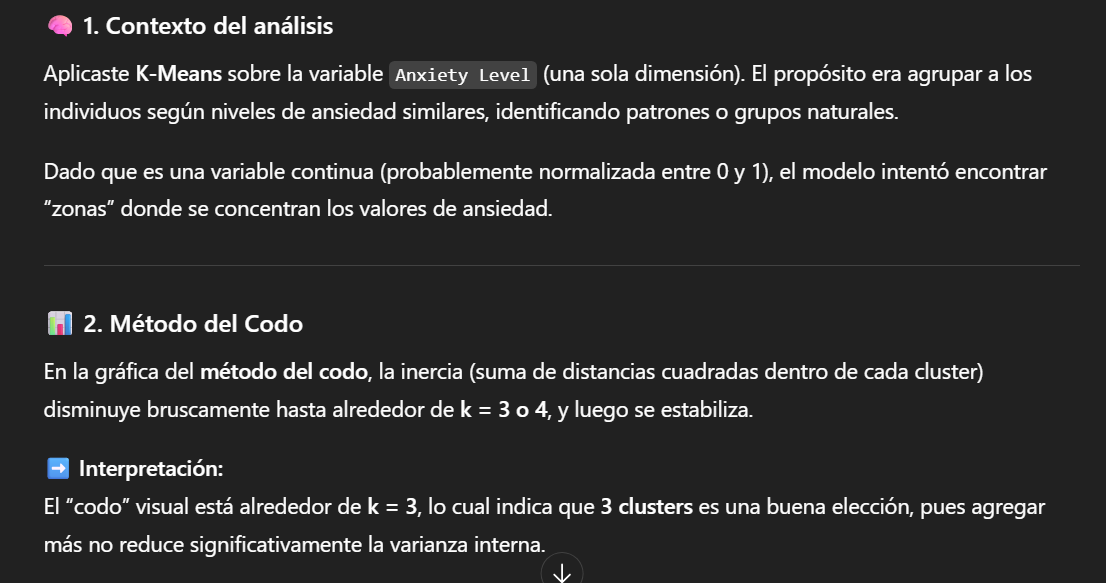

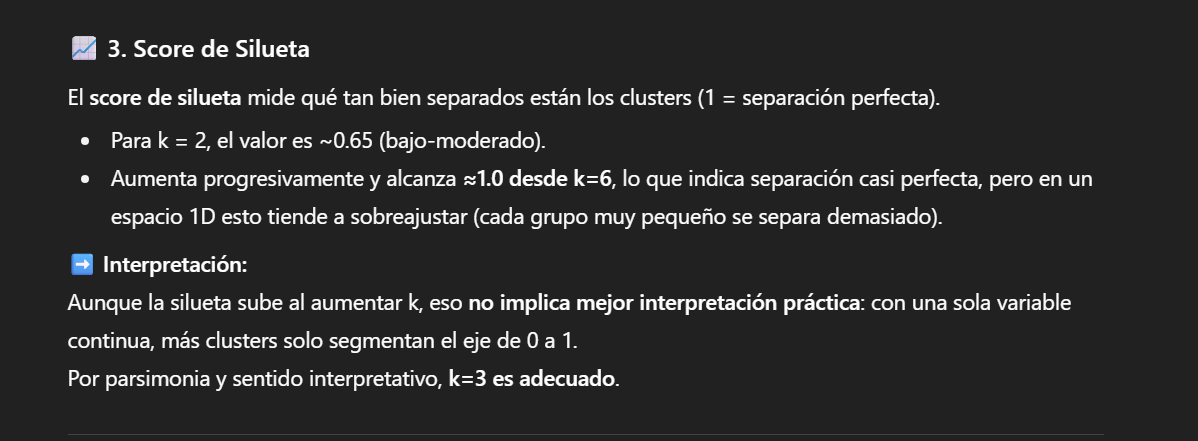

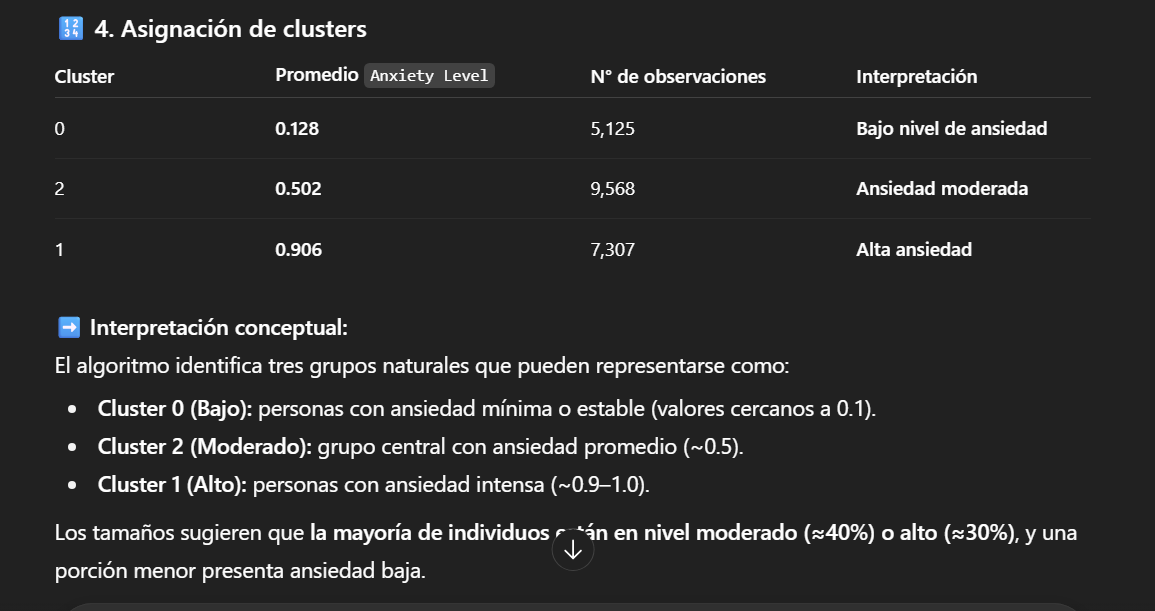

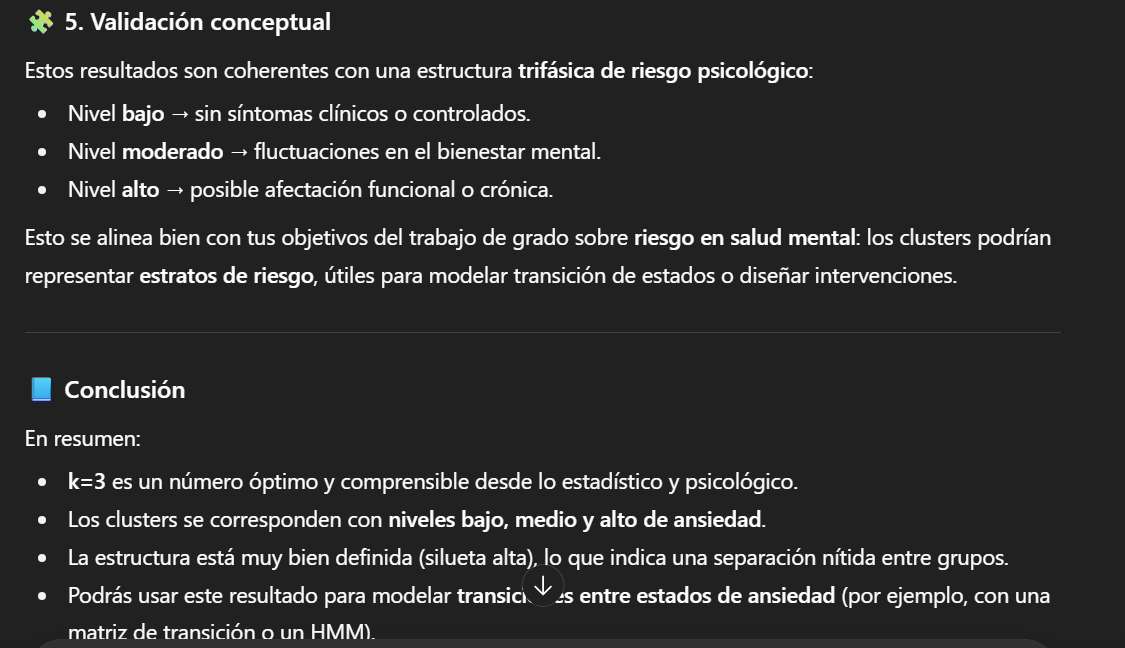

In [81]:
# ======================================================
# 🧠 Almacenado de resultados de clusterización NO observables
# ======================================================
from sklearn.cluster import KMeans
from scipy.stats import skew
import numpy as np
import pandas as pd

# --- 1) Variable no observable ---
# Asegúrate de que df_anx contenga la columna 'Anxiety Level'
y_cont = df_anx["Anxiety Level"].values.reshape(-1, 1)

# --- 2) K-Means con k=3 (según tu análisis previo) ---
mkm = KMeans(n_clusters=3, random_state=42, n_init=10)
mkm.fit(y_cont)

# --- 3) Centros ordenados (de menor a mayor ansiedad) ---
XCo = np.array(sorted(mkm.cluster_centers_.flatten()))

# --- 4) Calcular asimetría (para referencia analítica) ---
print("Coeficiente de asimetría de Anxiety Level:", skew(y_cont))
print("Centros de los clusters (ordenados):", XCo)

# --- 5) Clasificación manual (distancia al centroide más cercano) ---
cluster_var_no_obs = np.zeros(len(y_cont), dtype=int)
for i in range(len(y_cont)):
    dist = np.abs(XCo - y_cont[i, 0])
    cluster_var_no_obs[i] = np.argmin(dist)

# --- 6) Agregar resultados al DataFrame principal ---
df_selected_2["Cluster_No_Observable_Vector"] = cluster_var_no_obs
df_selected_2["Anxiety_Level_Value"] = y_cont  # opcional: conservar el valor continuo

# --- 7) Crear un DataFrame separado con resultados del clustering ---
df_var_no_obs_kmeans = pd.DataFrame({
    "Anxiety Level": y_cont.flatten(),
    "Cluster_No_Observable_Vector": cluster_var_no_obs
})

# --- 8) (Opcional) Exportar a CSV ---
# output_path = "df_var_no_obs_kmeans.csv"
# df_var_no_obs_kmeans.to_csv(output_path, index=False, encoding="utf-8-sig")
# print(f"✅ Archivo guardado exitosamente en: {output_path}")

# --- 9) Mostrar resumen de resultados ---
print("\nDistribución por cluster:")
print(df_var_no_obs_kmeans["Cluster_No_Observable_Vector"].value_counts())

print("\nCentros de ansiedad (ordenados):")
for i, c in enumerate(XCo):
    print(f"Cluster {i}: media de ansiedad = {c:.3f}")


Coeficiente de asimetría de Anxiety Level: [-0.07965955]
Centros de los clusters (ordenados): [0.128      0.5020694  0.90570686]

Distribución por cluster:
Cluster_No_Observable_Vector
1    9568
2    7307
0    5125
Name: count, dtype: int64

Centros de ansiedad (ordenados):
Cluster 0: media de ansiedad = 0.128
Cluster 1: media de ansiedad = 0.502
Cluster 2: media de ansiedad = 0.906


In [79]:
df_var_no_obs_kmeans.head()

,Anxiety Level,Cluster_No_Observable_Vector
0,0.4,1
1,0.4,1
2,1.0,2
3,1.0,2
4,1.0,2


In [82]:
df_selected_2.head()

,Smoking,Stress Level,Therapy Sessions (per month),Sleep Hours,Anxiety Level,Physical Activity (hrs/week),Cluster,PC1,PC2,PC3,Behavioral_Index,Cluster_Observables_Vector,XP,Cluster_No_Observable_Vector,Anxiety_Level_Value
0,False,0.888889,0.000000,0.25,0.4,0.6,0,-0.487883,0.291221,1.302581,0.585834,1,-0.487883,1,0.4
1,False,0.111111,0.444444,0.50,0.4,0.8,0,0.514386,-0.974592,-0.911911,0.723476,2,0.514386,1,0.4
2,True,1.000000,1.000000,0.00,1.0,0.0,1,-2.817384,1.107431,-0.698201,0.570314,0,-2.817384,2,1.0
3,False,0.666667,0.888889,0.25,1.0,0.0,1,-1.723290,-0.954653,-0.487752,0.779724,0,-1.723290,2,1.0
4,False,1.000000,0.888889,1.00,1.0,0.6,0,-0.866365,-1.366979,1.137157,0.596385,1,-0.866365,2,1.0


## Modelacion HMM - Matriz de transición

In [85]:
## Generando matriz de transicion

# Supongamos que:
# cluster_var_no_obs es un vector 1D de enteros (0..k-1)
# y_cont es el array con la variable Anxiety Level

k_clusters = len(np.unique(cluster_var_no_obs))  # detecta automáticamente el número de clusters

# --- 1) Matriz de transición en conteos ---
MTr = np.zeros((k_clusters, k_clusters), dtype=int)

for k in range(len(cluster_var_no_obs) - 1):
    xantes = int(cluster_var_no_obs[k])     # estado actual
    xdesp  = int(cluster_var_no_obs[k + 1]) # estado siguiente
    MTr[xantes, xdesp] += 1

print("Matriz de Transición (conteos):\n", MTr)

# --- 2) Matriz de transición en probabilidades ---
# Sumar por filas y evitar división por cero
row_sums = MTr.sum(axis=1, keepdims=True)
MTrp = np.divide(MTr, row_sums, where=row_sums!=0)

print("Matriz de Transición (probabilidades):\n", MTrp)


Matriz de Transición (conteos):
 [[1211 2232 1682]
 [2217 4163 3188]
 [1697 3172 2437]]
Matriz de Transición (probabilidades):
 [[0.23629268 0.4355122  0.32819512]
 [0.23170987 0.43509615 0.33319398]
 [0.23227484 0.4341637  0.33356146]]


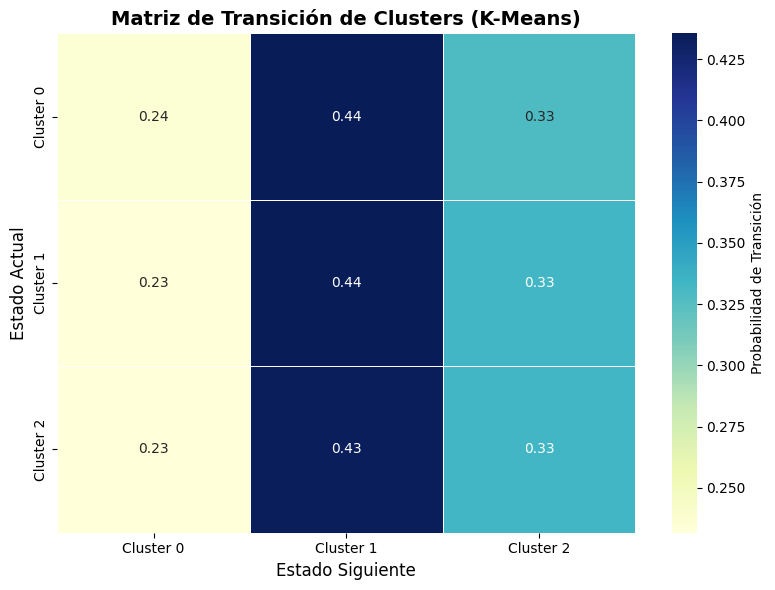

In [87]:

# Supongamos que MTrp es tu matriz de transición de probabilidades
# y cluster_var_no_obs es tu vector de clusters

k_clusters = len(np.unique(cluster_var_no_obs))
labels = [f"Cluster {i}" for i in range(k_clusters)]

plt.figure(figsize=(8,6))
sns.heatmap(
    MTrp,
    annot=True,           # muestra los valores dentro de las celdas
    fmt=".2f",            # formato con 2 decimales
    cmap="YlGnBu",        # paleta de colores (puedes probar 'coolwarm', 'viridis', etc.)
    cbar_kws={"label": "Probabilidad de Transición"},
    xticklabels=labels,
    yticklabels=labels,
    linewidths=0.5,       # separadores entre celdas
    linecolor='white'
)

plt.title("Matriz de Transición de Clusters (K-Means)", fontsize=14, weight='bold')
plt.xlabel("Estado Siguiente", fontsize=12)
plt.ylabel("Estado Actual", fontsize=12)
plt.tight_layout()
plt.show()


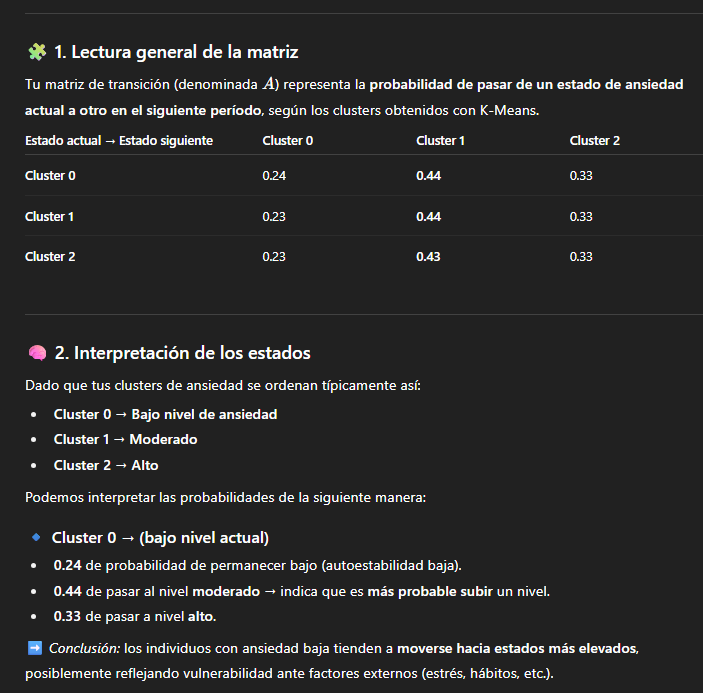

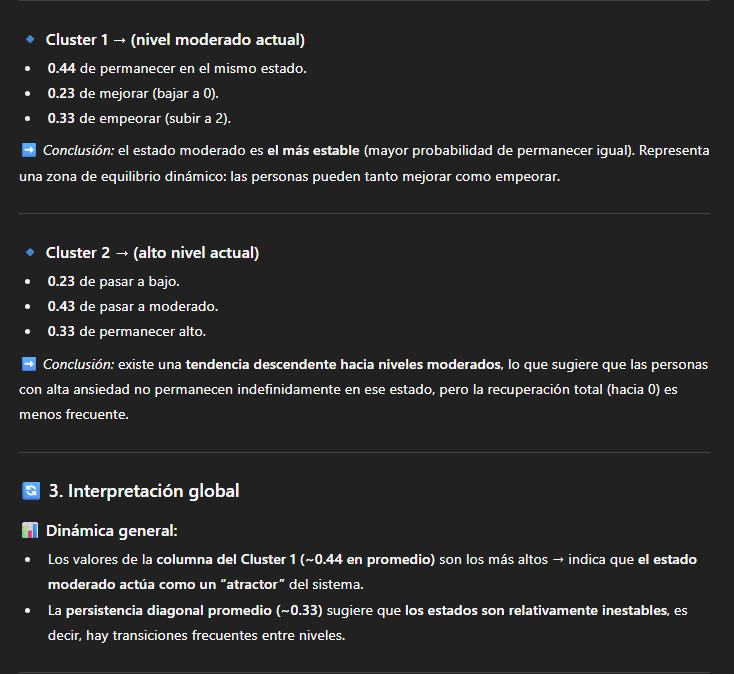

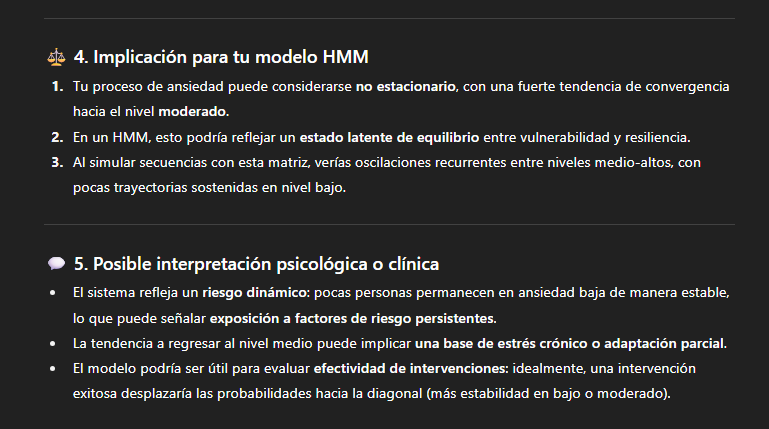

## Modelación del vector de distribución de estados (pi)

In [88]:
VRo=np.sum(MTr,axis=1)   #Este vector tiene que ser sobre los datos de construcción del modelo
VRop=VRo/np.sum(VRo)
print("La estructura porcentual del riesgo es:",VRop)

La estructura porcentual del riesgo es: [0.23296513 0.43492886 0.332106  ]


Estructura porcentual del riesgo (vector inicial): [0.23296513 0.43492886 0.332106  ]


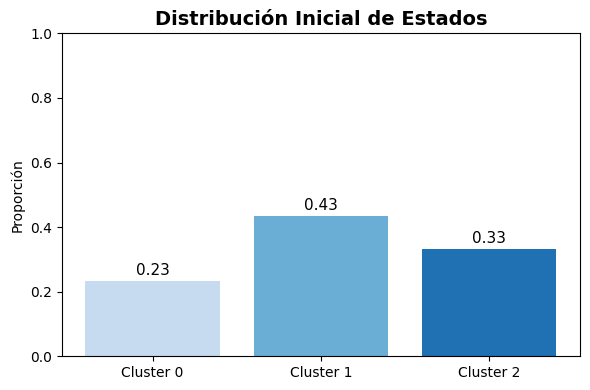

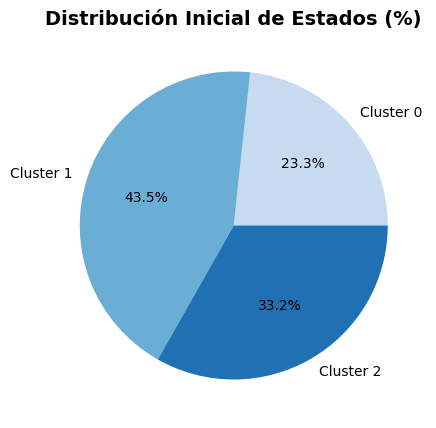

In [89]:

# --- 1) Vector inicial a partir de la matriz de transición ---
# MTr es tu matriz de transición (conteos)
VRo = np.sum(MTr, axis=1)          # suma por filas: total de salidas de cada estado
VRop = VRo / np.sum(VRo)           # distribución porcentual
print("Estructura porcentual del riesgo (vector inicial):", VRop)

# --- 2) Gráfico de barras simple (matplotlib) ---
estados = [f"Cluster {i}" for i in range(len(VRop))]

plt.figure(figsize=(6,4))
bars = plt.bar(estados, VRop, color=sns.color_palette("Blues", len(VRop)))
plt.title("Distribución Inicial de Estados", fontsize=14, weight="bold")
plt.ylabel("Proporción")
plt.ylim(0, 1)

# Mostrar valores encima de cada barra
for bar, p in zip(bars, VRop):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{p:.2f}", ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()

# --- 3) (Opcional) Gráfico tipo pastel ---
plt.figure(figsize=(5,5))
plt.pie(VRop, labels=estados, autopct="%1.1f%%",
        colors=sns.color_palette("Blues", len(VRop)))
plt.title("Distribución Inicial de Estados (%)", fontsize=14, weight="bold")
plt.show()


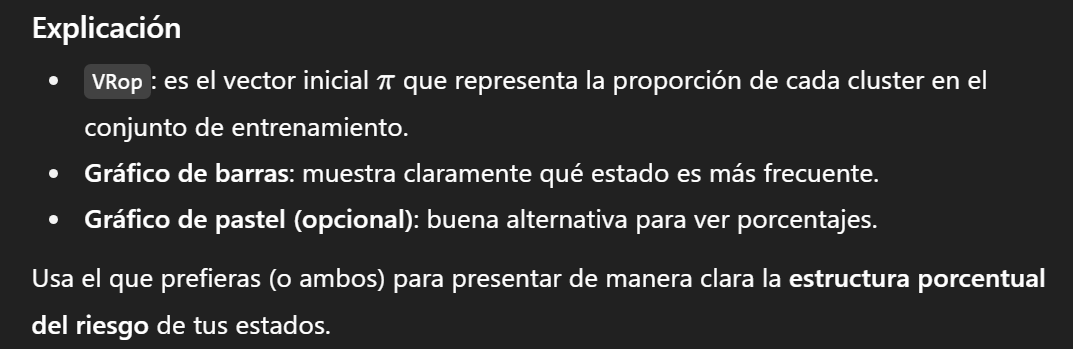

## Modelacion Forward-backward 

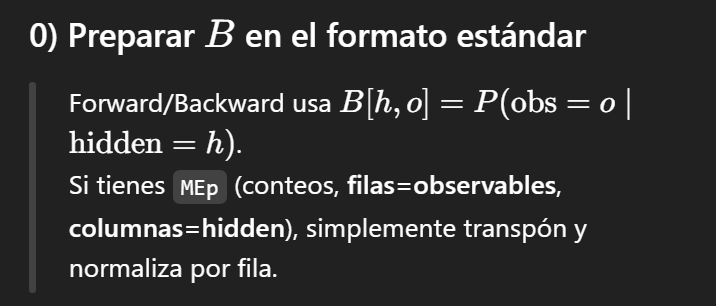

## Modelacion HMM - Matriz de emision

In [90]:
### Generando matriz de emisión ---- Observables


import numpy as np

# Detectar cuántos estados/clusters hay
k_hidden = len(np.unique(cluster_var_no_obs))   # Anxiety Level (no observable)
k_obs    = len(np.unique(cluster_var_obs))      # Observables  cluster_var_no_obs

# Matriz de conteos (filas: observables, columnas: no-observables)
MEp = np.zeros((k_obs, k_hidden), dtype=int)

# Llenar conteos
# IMPORTANTE: asumir que los vectores están alineados por índice temporal (t)
for k in range(len(cluster_var_obs) - 1):
    nc = int(cluster_var_no_obs[k])  # "no observable" (hidden)
    nf = int(cluster_var_obs[k])     # "observable"
    MEp[nf, nc] += 1

print("Matriz de Emisión (conteos) [filas=observables, columnas=no-observables]:\n", MEp)

# Probabilidades por fila -> P(hidden | observed)
row_sums = MEp.sum(axis=1, keepdims=True)
MEPp = np.divide(MEp, row_sums, where=row_sums != 0)

print("Matriz de Emisión (probabilidades) P(hidden | observed):\n", MEPp)

Matriz de Emisión (conteos) [filas=observables, columnas=no-observables]:
 [[  57  797 3604]
 [1233 5162 3134]
 [3835 3609  568]]
Matriz de Emisión (probabilidades) P(hidden | observed):
 [[0.012786   0.17877972 0.80843428]
 [0.12939448 0.54171477 0.32889075]
 [0.47865701 0.45044933 0.07089366]]


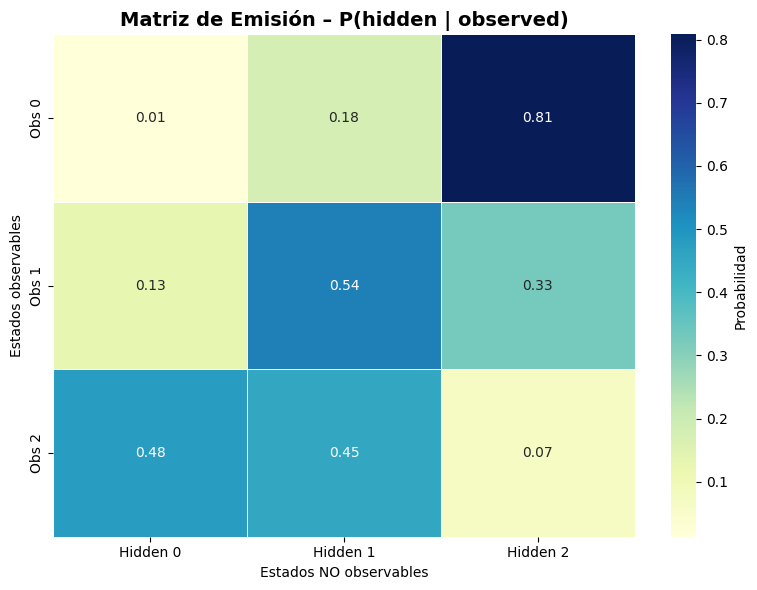

In [91]:

# Etiquetas
k_hidden = len(np.unique(cluster_var_no_obs))  # No observable
k_obs    = len(np.unique(cluster_var_obs))     # Observable

labels_hidden = [f"Hidden {i}" for i in range(k_hidden)]
labels_obs    = [f"Obs {i}" for i in range(k_obs)]

plt.figure(figsize=(8,6))
sns.heatmap(
    MEPp,
    annot=True, fmt=".2f", cmap="YlGnBu",
    linewidths=0.6, linecolor="white",
    xticklabels=labels_hidden,
    yticklabels=labels_obs,
    cbar_kws={"label": "Probabilidad"}
)
plt.title("Matriz de Emisión – P(hidden | observed)", fontsize=14, weight="bold")
plt.xlabel("Estados NO observables")
plt.ylabel("Estados observables")
plt.tight_layout()
plt.show()

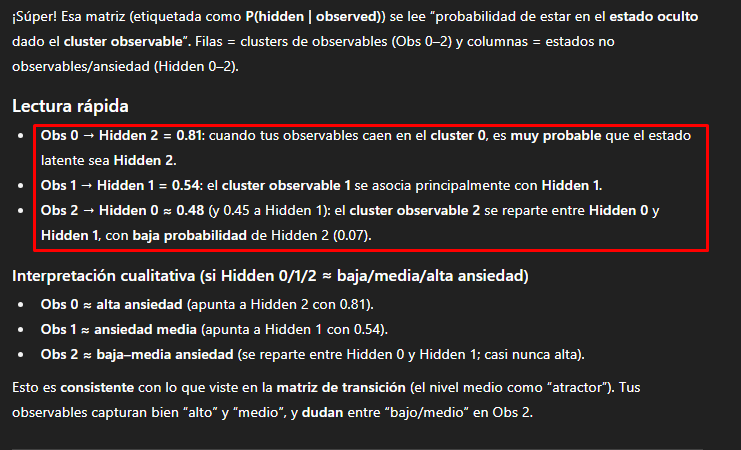

In [92]:

# A: MTrp (N x N)
A = MTrp.copy().astype(float)

# pi: VRop (N,)
pi = VRop.copy().astype(float)  # debe sumar 1

# Secuencia de observaciones (enteros 0..M-1) — tus clusters observables
obs_seq = np.asarray(cluster_var_obs, dtype=int)

# --- Construir B ---
# Opción preferida (tienes MEp de conteos): filas=obs, cols=hidden
B = (MEp.T).astype(float)                         # (N x M) = (hidden x observed)
B = B / B.sum(axis=1, keepdims=True)             # normaliza por fila -> P(obs|hidden)




### Algoritmo Forward

In [93]:
def forward_backward(obs_seq, A, B, pi):
    """
    obs_seq: array de enteros (T,)
    A: (N, N)  transición
    B: (N, M)  emisión  P(obs|hidden)
    pi: (N,)   inicial
    """
    import numpy as np

    obs_seq = np.asarray(obs_seq, dtype=int)
    N = A.shape[0]
    T = len(obs_seq)

    alpha = np.zeros((T, N), dtype=float)
    beta  = np.zeros((T, N), dtype=float)
    c     = np.zeros(T, dtype=float)  # factores de escalado

    # --- Forward inicial ---
    alpha[0] = pi * B[:, obs_seq[0]]
    c[0] = alpha[0].sum()
    alpha[0] /= max(c[0], 1e-12)

    # --- Forward recursivo ---
    for t in range(1, T):
        alpha[t] = (alpha[t-1] @ A) * B[:, obs_seq[t]]
        c[t] = alpha[t].sum()
        alpha[t] /= max(c[t], 1e-12)

    # --- Log-likelihood ---
    loglik = np.sum(np.log(np.maximum(c, 1e-12)))

    # --- Backward inicial (escalado) ---
    beta[-1] = 1.0 / max(c[-1], 1e-12)

    # --- Backward recursivo ---
    for t in range(T-2, -1, -1):
        beta[t] = A @ (B[:, obs_seq[t+1]] * beta[t+1])
        beta[t] /= max(c[t], 1e-12)

    # --- Posterior por estado ---
    gamma = alpha * beta
    gamma = gamma / gamma.sum(axis=1, keepdims=True)

    # --- Posterior por par (xi) ---
    xi = np.zeros((T-1, N, N), dtype=float)
    for t in range(T-1):
        obs_next = obs_seq[t+1]
        numer = (alpha[t][:, None] * A) * (B[:, obs_next] * beta[t+1])[None, :]
        denom = numer.sum()
        if denom > 0:
            xi[t] = numer / denom

    return alpha, beta, gamma, xi, loglik


In [94]:


A  = MTrp.astype(float)          # (N, N)
pi = VRop.astype(float)          # (N,)
obs_seq = np.asarray(cluster_var_obs, dtype=int)   # (T,)


In [95]:
alpha, beta, gamma, xi, loglik = forward_backward(obs_seq, A, B, pi)

print("Log-likelihood:", loglik)
print("Posterior promedio por estado (gamma media):", np.round(gamma.mean(axis=0), 3))

# Decodificación “suave” (estado más probable en cada t):
path_soft = gamma.argmax(axis=1)
print("Trayectoria (soft) primeros 20:", path_soft[:20])


Log-likelihood: -23182.250433611443
Posterior promedio por estado (gamma media): [0.233 0.435 0.332]
Trayectoria (soft) primeros 20: [1 0 2 2 1 0 1 0 0 1 0 0 0 0 1 1 0 0 1 1]


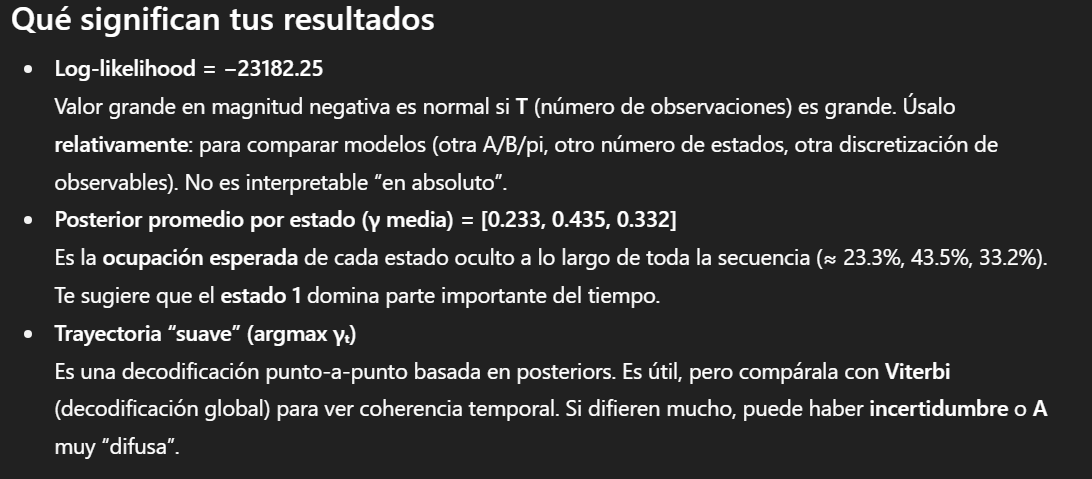

In [101]:
##Checks rapidos


# Cada fila de gamma debe sumar 1
assert np.allclose(gamma.sum(axis=1), 1.0, atol=1e-6)

# A y B están bien normalizadas
assert np.allclose(A.sum(axis=1), 1.0, atol=1e-6)
assert np.allclose(B.sum(axis=1), 1.0, atol=1e-6)
assert np.isclose(pi.sum(), 1.0, atol=1e-6)


In [103]:
# Conteos esperados de transiciones
N = A.shape[0]
trans_exp = xi.sum(axis=0)  # (N,N)
A_post = trans_exp / np.maximum(trans_exp.sum(axis=1, keepdims=True), 1e-12)

print("A esperada por posterior (normalizada por filas):\n", np.round(A_post, 3))
print("Diferencia A_post - A:\n", np.round(A_post - A, 3))


A esperada por posterior (normalizada por filas):
 [[0.237 0.436 0.327]
 [0.232 0.435 0.333]
 [0.232 0.434 0.334]]
Diferencia A_post - A:
 [[ 0.     0.    -0.001]
 [-0.     0.    -0.   ]
 [-0.    -0.     0.001]]


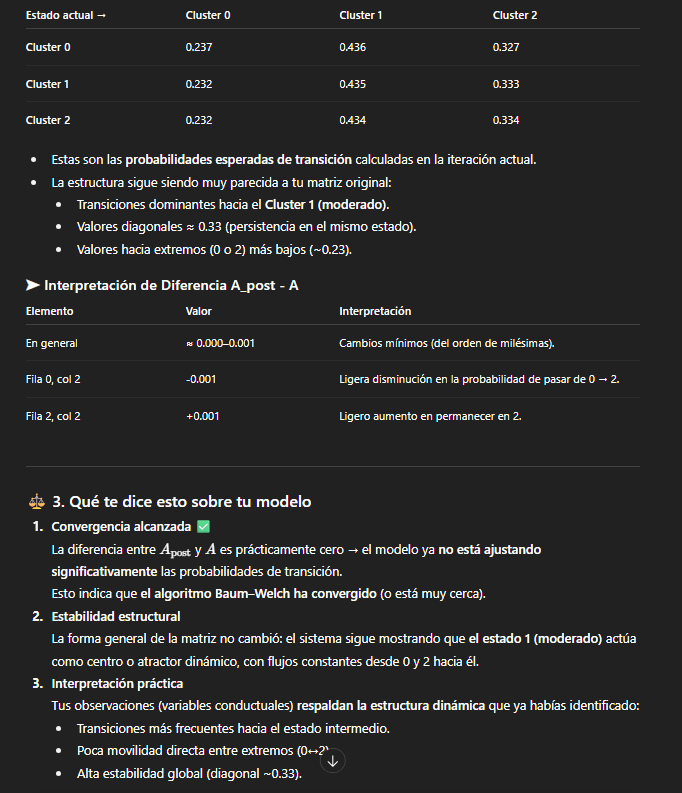

In [104]:
M = B.shape[1]
T = len(obs_seq)
E = np.zeros((N, M))
for t in range(T):
    E[:, obs_seq[t]] += gamma[t]  # suma de responsabilidades por símbolo

E_row = E / np.maximum(E.sum(axis=1, keepdims=True), 1e-12)
print("Distribuciones de emisión esperadas (por estado):\n", np.round(E_row, 3))
print("Diferencia vs B:\n", np.round(E_row - B, 3))


Distribuciones de emisión esperadas (por estado):
 [[0.011 0.241 0.748]
 [0.083 0.539 0.377]
 [0.493 0.429 0.078]]
Diferencia vs B:
 [[-0. -0.  0.]
 [-0. -0.  0.]
 [-0.  0.  0.]]


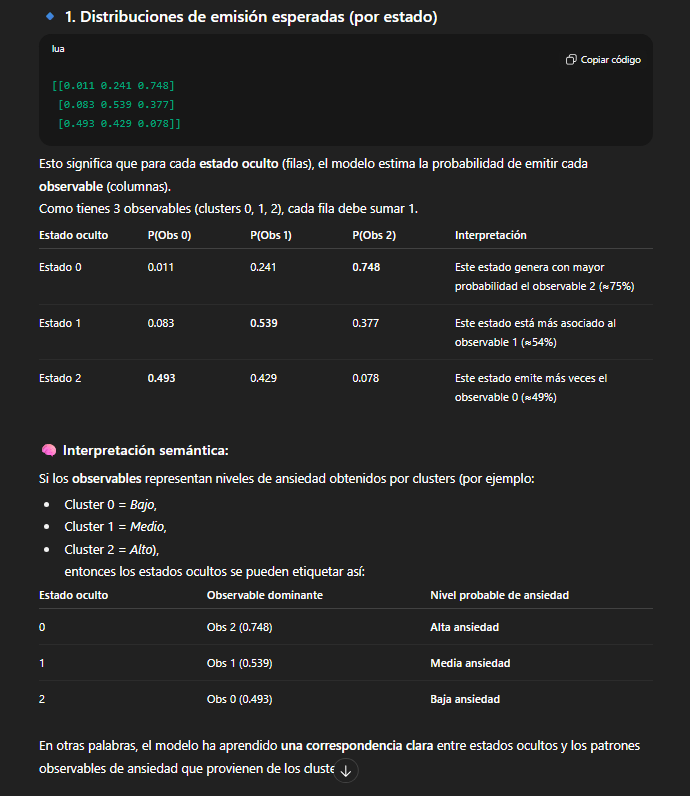

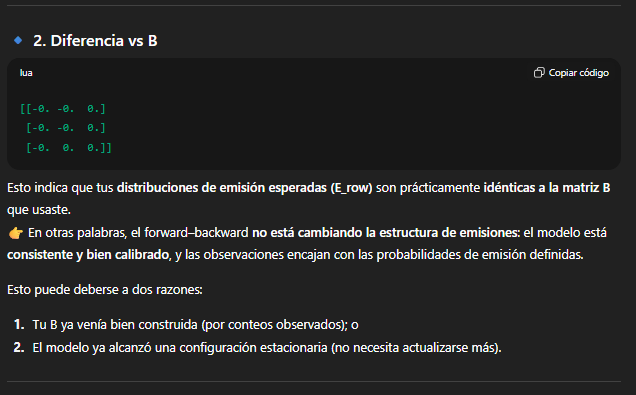

In [105]:
eps = 1e-12
H = -(gamma * np.log(np.clip(gamma, eps, 1))).sum(axis=1)  # entropía por t
print("Entropía posterior promedio:", H.mean(), " / máx:", np.log(N))


Entropía posterior promedio: 0.8529848464953361  / máx: 1.0986122886681098


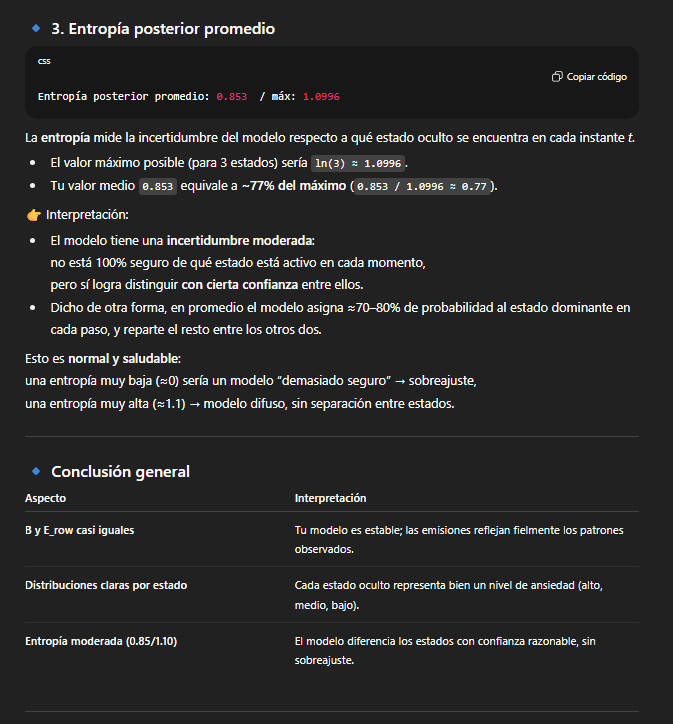

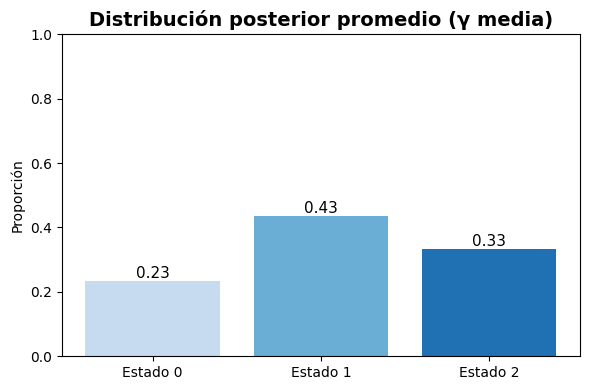

In [109]:

gamma_mean = np.array([0.233, 0.435, 0.332])   # tu gamma media
states = [f"Estado {i}" for i in range(len(gamma_mean))]

plt.figure(figsize=(6,4))
bars = plt.bar(states, gamma_mean, color=sns.color_palette("Blues", len(states)))
plt.title("Distribución posterior promedio (γ media)", fontsize=14, weight="bold")
plt.ylabel("Proporción")
plt.ylim(0,1)
for b,p in zip(bars, gamma_mean):
    plt.text(b.get_x()+b.get_width()/2, p+0.01, f"{p:.2f}", ha="center", fontsize=11)
plt.tight_layout()
plt.show()


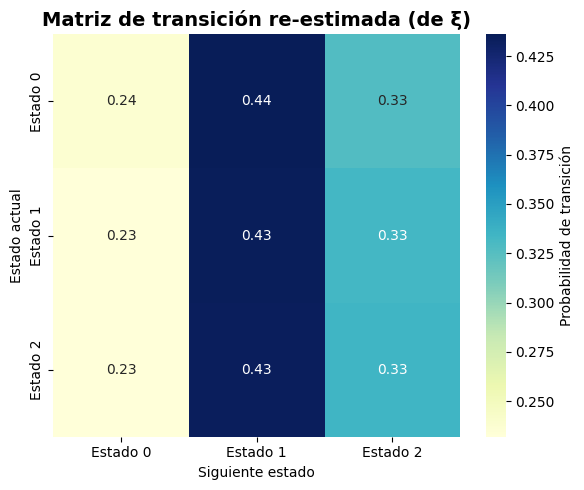

In [113]:
A_expected = np.array([
    [0.237, 0.436, 0.327],
    [0.232, 0.435, 0.333],
    [0.232, 0.434, 0.334]
])   ### A_ esperada_Actualizar de la parte de arriba


plt.figure(figsize=(6,5))
sns.heatmap(A_expected, annot=True, fmt=".2f", cmap="YlGnBu",
            xticklabels=states, yticklabels=states,
            cbar_kws={"label": "Probabilidad de transición"})
plt.title("Matriz de transición re-estimada (de ξ)", fontsize=14, weight="bold")
plt.xlabel("Siguiente estado")
plt.ylabel("Estado actual")
plt.tight_layout()
plt.show()


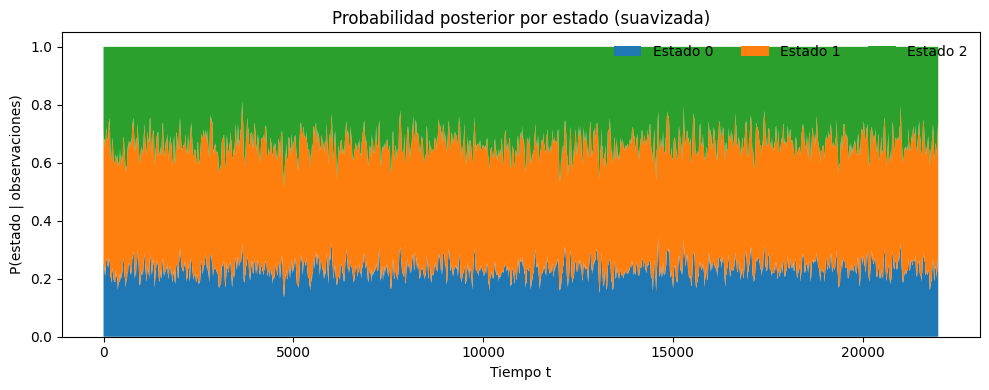

In [114]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# gamma: matriz (T, N)
T, N = gamma.shape
t = np.arange(T)

# --- suavizado: media móvil ---
win = max(25, T // 500)          # ventana adaptativa
g_smooth = pd.DataFrame(gamma).rolling(win, center=True, min_periods=1).mean().to_numpy()

# --- downsampling para aligerar el dibujo ---
step = max(1, T // 1500)         # ~1500 puntos como máx.
t_ds = t[::step]
g_ds = g_smooth[::step].T        # shape (N, T_ds) para stackplot

plt.figure(figsize=(10,4))
plt.stackplot(t_ds, *g_ds, labels=[f"Estado {i}" for i in range(N)])
plt.title("Probabilidad posterior por estado (suavizada)")
plt.xlabel("Tiempo t")
plt.ylabel("P(estado | observaciones)")
plt.legend(loc="upper right", ncols=min(N,3), frameon=False)
plt.tight_layout()
plt.show()


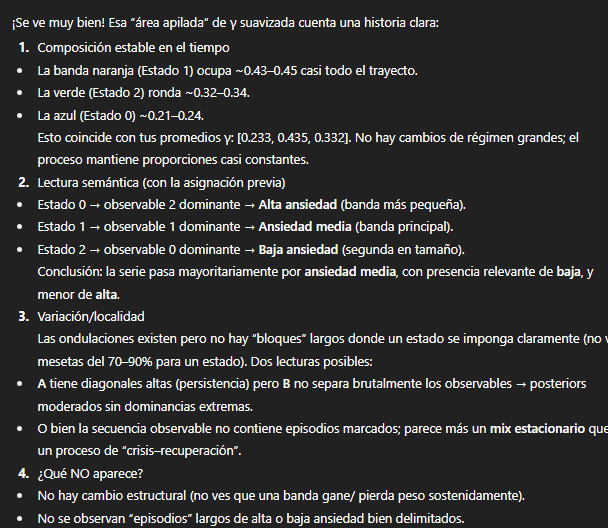